In [ ]:
#!pip install openml optuna

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
import openml
import random
import joblib
import os

pd.set_option('display.max_colwidth', None)

exp_id = '20240812' #'20240323' #'20240216'
output_root = f'./output/{exp_id}/'
os.makedirs(output_root, exist_ok=True)

def fetch_open_ml_data(dataset_id):

    dataset = openml.datasets.get_dataset(dataset_id)
    
    print(f'Dataset name: {dataset.name}')
    
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="array", target=dataset.default_target_attribute
    )
    df = pd.DataFrame(X, columns=attribute_names)
    df["target"] = y
    
    return df, 'target', dataset.name

def prepare_data(df, target_name):
    """Simple preprocessing wrapper function
    :param df. pandas dataframe containing dataset
    :param target_name. the name of the target variable column
    :return data dict containing the preprocessed pandas dataframes"""
    y = df[target_name]
    X = df.drop(target_name, axis=1)
    X.fillna(0, inplace=True)

    return X, y

def _calculate_dataset_size(X):
    return {"n_samples": X.shape[0], "n_features": X.shape[1]}

def _calculate_class_imbalance_ratio(y):
    """
    Calculate the class imbalance ratio of a dataset.

    Parameters:
    y: array-like, shape (n_samples,)
       Target values (class labels).

    Returns:
    float: The ratio of the majority class size to the minority class size.
    """
    # Count the occurrences of each class
    class_counts = np.bincount(y)

    # Find the counts of majority and minority classes
    majority_class_count = np.max(class_counts)
    minority_class_count = np.min(class_counts)

    # Calculate the imbalance ratio
    imbalance_ratio = majority_class_count / minority_class_count

    return {"imbalance_ratio": imbalance_ratio}

def _calculate_correlation_metrics(X, y, correlation_cutoff=0.1):
    """
    Calculates and returns correlation metrics between features in X and the target variable y,
    filtering for features that have a correlation above a specified cutoff.

    Parameters:
    - X (array-like, DataFrame): The input features, where rows represent samples and columns represent features.
    - y (array-like, Series): The target variable for which correlations with features in X are computed.
    - correlation_cutoff (float, optional): The minimum absolute correlation value for a feature to be considered
      informative with respect to the target variable. Defaults to 0.1.

    Returns:
    - dict: A dictionary containing the following key-value pairs:
        - 'n_highly_target_corr': The number of features that have an absolute correlation with the target
          variable greater than the specified cutoff.
        - 'avg_target_corr': The average absolute correlation of all features with the target variable.
        - 'var_target_corr': The variance of the absolute correlations of all features with the target variable.

    Note:
    - The function uses Pearson correlation by default but can be adjusted to use 'spearman' or 'kendall'
      for non-linear relationships by modifying the `corr` method call.
    """
    df = pd.DataFrame(X.copy())
    df['target'] = pd.Series(y.copy())
    correlation_matrix = df.corr(method='pearson')  # Use 'spearman' or 'kendall' for non-linear relationships
    correlations_with_target = abs(correlation_matrix['target'])

    informative_features = correlations_with_target[correlations_with_target > correlation_cutoff].sort_values(ascending=False)
    n_informative = len(informative_features) - 1

    return {'n_highly_target_corr': n_informative  # Number of highly target correlated features 
            , 'avg_target_corr' : correlations_with_target.mean() # Avg target correlation
            , 'var_target_corr' : correlations_with_target.var() # Variance of target correlation
           }

def _calculate_feature_moments_and_variances(X):
    """
    Calculate the first four statistical moments (mean, variance, skewness, kurtosis), their averages,
    and variances for each feature in the dataset.

    Parameters:
    X (DataFrame): DataFrame containing the feature set.

    Returns:
    DataFrame: A DataFrame with the first four moments, their averages, and variances for each feature.
    """
    # Converting to DataFrame if not already (for compatibility)
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # Calculate first moment (mean) for each col
    moment_1 = X.apply(lambda x: x.mean(), axis=0)

    # Calculate second moment (variance) for each col
    moment_2 = X.apply(lambda x: x.var(), axis=0)

    # Calculate third moment (skewness) for each col
    moment_3 = X.apply(lambda x: skew(x.dropna()), axis=0)

    # Calculate fourth moment (kurtosis) for each col
    moment_4 = X.apply(lambda x: kurtosis(x.dropna()), axis=0)

    # Calculate and add the averages and variances of all moments
    moments = {'avg_feature_m1': moment_1.mean()  # Average Mean
              , 'var_feature_m1': moment_1.var()   # Variance of Mean
              , 'avg_feature_m2': moment_2.mean()  # Average Variance
              , 'var_feature_m2': moment_2.var()   # Variance of Variance
              , 'avg_feature_m3': moment_3.mean()  # Average Skewness
              , 'var_feature_m3': moment_3.var()   # Variance of Skewness
              , 'avg_feature_m4': moment_4.mean()  # Average Kurtosis
              , 'var_feature_m4': moment_4.var()   # Variance of Kurtosis  
              }

    return moments

def _calculate_row_moments_and_variances(X):
    """
    Calculate the first four statistical moments (mean, variance, skewness, kurtosis), their averages,
    and variances for each row in the dataset.

    Parameters:
    X (DataFrame): DataFrame containing the feature set.

    Returns:
    DataFrame: A DataFrame with the first four moments, their averages, and variances for each row.
    """
    # Converting to DataFrame if not already (for compatibility)
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # Calculate first moment (mean) for each row
    moment_1 = X.apply(lambda x: x.mean(), axis=1)

    # Calculate second moment (variance) for each row
    moment_2 = X.apply(lambda x: x.var(), axis=1)

    # Calculate third moment (skewness) for each row
    moment_3 = X.apply(lambda x: skew(x.dropna()), axis=1)

    # Calculate fourth moment (kurtosis) for each row
    moment_4 = X.apply(lambda x: kurtosis(x.dropna()), axis=1)

    # Calculate and add the averages and variances of all moments
    moments = {'avg_row_m1': moment_1.mean()  # Average Mean
              , 'var_row_m1': moment_1.var()   # Variance of Mean
              , 'avg_row_m2': moment_2.mean()  # Average Variance
              , 'var_row_m2': moment_2.var()   # Variance of Variance
              , 'avg_row_m3': moment_3.mean()  # Average Skewness
              , 'var_row_m3': moment_3.var()   # Variance of Skewness
              , 'avg_row_m4': moment_4.mean()  # Average Kurtosis
              , 'var_row_m4': moment_4.var()   # Variance of Kurtosis  
              }

    return moments

def _calculate_skewness_kurtosis_stats(X):
    """
    Calculate the skewness and kurtosis for each numerical feature in the dataset.

    Parameters:
    X (DataFrame): DataFrame containing the feature set.

    Returns:
    DataFrame: A DataFrame with skewness and kurtosis for each feature.
    """
    # Converting to DataFrame if not already (for compatibility)
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # Calculate skewness and kurtosis for each feature
    skewness = X.apply(lambda x: skew(x.dropna()), axis=0)
    kurtosis_values = X.apply(lambda x: kurtosis(x.dropna()), axis=0)

    # Calculate average and standard deviation of skewness and kurtosis
    skewness_kurtosis_stats = {
        'average_skewness': skewness.mean(),
        'std_dev_skewness': skewness.std(),
        'average_kurtosis': kurtosis_values.mean(),
        'std_dev_kurtosis': kurtosis_values.std()
    }
    
    return skewness_kurtosis_stats


def calculate_dataset_meta_parameters(X, y):
    
    meta_parameters = {}
    meta_parameters.update( _calculate_dataset_size(X) )
    meta_parameters.update( _calculate_class_imbalance_ratio(y) )
    meta_parameters.update( _calculate_correlation_metrics(X, y, correlation_cutoff=0.10) )
    meta_parameters.update( _calculate_feature_moments_and_variances(X) )
    meta_parameters.update( _calculate_row_moments_and_variances(X) ) # experimental 
    
    return meta_parameters

def _relative2absolute_dict_old(param_config, dataset_properties, param_dict):
    
    params_with_dependency = [param for param, details in param_config.items() if 'dependency' in details]
    for p in params_with_dependency:
        dependency_col = param_config[p]['dependency']
        dependency_value = dataset_properties[dependency_col]
        param_dict[p] = max(int(dependency_value * param_dict[p]),1)
        
    return param_dict


def _relative2absolute_dict(param_config, dataset_properties, param_dict):
    # Create a copy of the param_dict to avoid modifying the original
    absolute_param_dict = param_dict.copy()
    
    params_with_dependency = [param for param, details in param_config.items() if 'dependency' in details]
    for p in params_with_dependency:
        dependency_col = param_config[p]['dependency']
        dependency_value = dataset_properties[dependency_col]
        absolute_param_dict[p] = max(int(dependency_value * absolute_param_dict[p]), 1)
        
    return absolute_param_dict



def evaluate_model(X, y, model_name, hyperparams, random_seed=42, n_folds=3, n_seeds=20):
    seed_scores = []

    for i in range(n_seeds):
        seed = random_seed + i
        if model_name == "DecisionTreeClassifier2Param" or model_name == "DecisionTreeClassifier4Param":
            model = DecisionTreeClassifier(random_state=seed, **hyperparams)
        elif model_name == "RandomForestClassifier":
            model = RandomForestClassifier(random_state=seed, **hyperparams)
        elif model_name == "XGBClassifier":
            model = XGBClassifier(random_state=seed, **hyperparams)
        
        cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
        scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
        seed_scores.append(np.mean(scores))

    final_score = np.mean(seed_scores)
    return final_score, seed_scores


def _generate_random_params(param_config, random_seed):
    random_params = {}
    
    random.seed(random_seed)
    for param, config in param_config.items():
        min_value = min(config['percentage_splits'])
        max_value = max(config['percentage_splits'])
     
        random_params[param] = random.uniform(min_value, max_value)
    
    return random_params

def random_perf_wrapper_old(X, y, meta_params, random_seed=42, n_seeds=20):
    
    all_dataset_meta_params = calculate_dataset_meta_parameters(X, y)
    
    dataset_meta_params = {key: all_dataset_meta_params[key] for key in meta_params}
    dataset_meta_params_inc_dependencies = {key: all_dataset_meta_params[key] for key in ['n_samples']}
    dataset_meta_params_inc_dependencies.update(dataset_meta_params)
    
    rand_hyperparams = _generate_random_params(ml_config["param_config"], random_seed)
    rand_hyperparams_abs = _relative2absolute_dict(param_config, dataset_meta_params_inc_dependencies
                                                     , rand_hyperparams)
    
    
    rand_perf, rand_all_scores = evaluate_model(X, y, ml_config['name'], rand_hyperparams_abs, random_seed=random_seed, n_seeds=n_seeds)
    
    return rand_hyperparams, rand_perf, rand_all_scores


def random_perf_wrapper(X, y, meta_params, random_seed=42, n_seeds=20):
    all_dataset_meta_params = calculate_dataset_meta_parameters(X, y)
    
    dataset_meta_params = {key: all_dataset_meta_params[key] for key in meta_params}
    dataset_meta_params_inc_dependencies = {key: all_dataset_meta_params[key] for key in ['n_samples']}
    dataset_meta_params_inc_dependencies.update(dataset_meta_params)
    
    all_rand_perfs = []
    all_rand_scores = []
    
    for seed in range(n_seeds):
        # Generate random parameters for this seed
        rand_hyperparams = _generate_random_params(ml_config["param_config"], random_seed + seed)
        rand_hyperparams_abs = _relative2absolute_dict(param_config, dataset_meta_params_inc_dependencies, rand_hyperparams)
        
        # Evaluate the model for this seed
        rand_perf, rand_scores = evaluate_model(X, y, ml_config['name'], rand_hyperparams_abs, random_seed=random_seed + seed, n_seeds=1)
        
        # Store the performance and scores
        all_rand_perfs.append(rand_perf)
        all_rand_scores.extend(rand_scores)  # Use extend to flatten the list of scores
    
    # Calculate the average performance across all seeds
    avg_rand_perf = np.mean(all_rand_perfs)
    
    return rand_hyperparams, avg_rand_perf, all_rand_scores


import optuna
from optuna.trial import Trial

def _optuna_objective(trial: Trial, X, y, param_config, meta_params, dataset_meta_params, random_seed=42):
    
    # Generate hyperparameters based on the trial
    hyperparams = {}
    for param, config in param_config.items():
        if 'percentage_splits' in config:
            min_value = min(config['percentage_splits'])
            max_value = max(config['percentage_splits'])
            hyperparams[param] = trial.suggest_uniform(param, min_value, max_value)
        # Add other parameter types (e.g., suggest_int, suggest_loguniform) as needed

    predicted_hyperparams = _relative2absolute_dict(param_config, dataset_meta_params, hyperparams)
    
    score, _ = evaluate_model(X, y, "DecisionTreeClassifier4Param", predicted_hyperparams, random_seed)
    return score

def optuna_perf_wrapper(X, y, meta_params, zerotune_warmstart=None, random_seed=42, n_trials=100):
    all_dataset_meta_params = calculate_dataset_meta_parameters(X, y)
    dataset_meta_params = {key: all_dataset_meta_params[key] for key in meta_params}
    dataset_meta_params_inc_dependencies = {key: all_dataset_meta_params[key] for key in ['n_samples']}
    dataset_meta_params_inc_dependencies.update(dataset_meta_params)
    
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))
    
    if zerotune_warmstart:
        print("ZeroTune warm start:", predicted_hyperparams)
        # Enqueue the ZeroTune hyperparameters trial
        study.enqueue_trial(predicted_hyperparams)
        #print("Enqueued trial:", predicted_hyperparams)

    study.optimize(lambda trial: _optuna_objective(trial, X, y, ml_config["param_config"], meta_params, dataset_meta_params_inc_dependencies), n_trials=n_trials)

    best_hyperparams = study.best_params
    best_hyperparams = _relative2absolute_dict(param_config, dataset_parameters, best_hyperparams)

    best_perf, n_seed_scores = evaluate_model(X, y, "DecisionTreeClassifier4Param", best_hyperparams, random_seed=random_seed, n_seeds=20)
    
    return {"best_hyperparams":best_hyperparams, "best_perf": best_perf,"n_seed_scores": n_seed_scores
            , "df_trials":study.trials_dataframe() } 

def optuna_perf_wrapper_inc_seeds_old(X, y, meta_params, zerotune_params=None, n_trials=100, n_seeds=20):
    all_dataset_meta_params = calculate_dataset_meta_parameters(X, y)
    dataset_meta_params = {key: all_dataset_meta_params[key] for key in meta_params}
    dataset_meta_params_inc_dependencies = {key: all_dataset_meta_params[key] for key in ['n_samples']}
    dataset_meta_params_inc_dependencies.update(dataset_meta_params)
    
    results = []
    best_perfs = []

    for seed in range(n_seeds):
        study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
        
        if zerotune_params:
            #print("ZeroTune warm start:", zerotune_params)
            # Enqueue the ZeroTune hyperparameters trial
            study.enqueue_trial(zerotune_params)
        
        study.optimize(lambda trial: _optuna_objective(trial, X, y, ml_config["param_config"], meta_params, dataset_meta_params_inc_dependencies), n_trials=n_trials)
        
        best_hyperparams = study.best_params
        best_perf = study.best_value
        #best_hyperparams = _relative2absolute_dict(param_config, dataset_parameters, best_hyperparams)
        #best_perf, n_seed_scores = evaluate_model(X, y, "DecisionTreeClassifier4Param", best_hyperparams, random_seed=seed, n_seeds=1)
        
        # Get trials DataFrame and add seed column
        df_trials = study.trials_dataframe()
        df_trials['seed'] = seed
        
        result = {
            "best_hyperparams": best_hyperparams,
            "best_perf": best_perf,
            "df_trials": df_trials
        }
        results.append(result)
        best_perfs.append(best_perf)
    
    # Calculate the average of best_perf across all seeds
    average_best_perf = sum(best_perfs) / n_seeds
    
    # Combine all results into a single DataFrame for analysis
    combined_trials_df = pd.concat([result['df_trials'] for result in results], ignore_index=True)
    
    return {
        "all_results": results,
        "average_best_perf": average_best_perf,
        "n_seed_scores": best_perfs,
        "combined_trials_df": combined_trials_df
    }


def optuna_perf_wrapper_inc_seeds(X, y, meta_params, zerotune_params=None, n_trials=100, n_seeds=20, seed=None):
    all_dataset_meta_params = calculate_dataset_meta_parameters(X, y)
    dataset_meta_params = {key: all_dataset_meta_params[key] for key in meta_params}
    dataset_meta_params_inc_dependencies = {key: all_dataset_meta_params[key] for key in ['n_samples']}
    dataset_meta_params_inc_dependencies.update(dataset_meta_params)
    
    results = []
    best_perfs = []
    
    # Adjust the seeds to process
    seeds_to_process = [seed] if seed is not None else range(n_seeds)
    
    for seed_value in seeds_to_process:
        study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed_value))
        
        if zerotune_params:
            # Enqueue the ZeroTune hyperparameters trial
            study.enqueue_trial(zerotune_params)
        
        study.optimize(lambda trial: _optuna_objective(trial, X, y, ml_config["param_config"], meta_params, dataset_meta_params_inc_dependencies), n_trials=n_trials)
        
        best_hyperparams = study.best_params
        best_perf = study.best_value
        
        # Get trials DataFrame and add seed column
        df_trials = study.trials_dataframe()
        df_trials['seed'] = seed_value
        
        result = {
            "best_hyperparams": best_hyperparams,
            "best_perf": best_perf,
            "df_trials": df_trials
        }
        results.append(result)
        best_perfs.append(best_perf)
    
    # Calculate the average of best_perf across all seeds
    average_best_perf = sum(best_perfs) / len(best_perfs)
    
    # Combine all results into a single DataFrame for analysis
    combined_trials_df = pd.concat([result['df_trials'] for result in results], ignore_index=True)
    
    return {
        "all_results": results,
        "average_best_perf": average_best_perf,
        "n_seed_scores": best_perfs,
        "combined_trials_df": combined_trials_df
    }


####################################
####################################

DECISION_TREE_CL_CONFIG_4PARAM = {"name": "DecisionTreeClassifier4Param",
                           "model": DecisionTreeClassifier(random_state=42),
                           'metric': 'roc_auc',
                           'param_config':{
                               'max_depth': {'percentage_splits': [0.25, 0.50, 0.70, 0.8, 0.9, 0.999], 'param_type':"int", 'dependency':'n_samples'},
                               'min_samples_split': {'percentage_splits': [0.005, 0.01, 0.02, 0.05, 0.10], 'param_type':"float"},
                               'min_samples_leaf': {'percentage_splits': [0.005, 0.01, 0.02, 0.05, 0.10], 'param_type':"float"},
                               'max_features': {'percentage_splits': [0.50, 0.70, 0.8, 0.9, 0.99], 'param_type':"float"}
                           }
                          }


ml_config = DECISION_TREE_CL_CONFIG_4PARAM
print(ml_config)

{'name': 'DecisionTreeClassifier4Param', 'model': DecisionTreeClassifier(random_state=42), 'metric': 'roc_auc', 'param_config': {'max_depth': {'percentage_splits': [0.25, 0.5, 0.7, 0.8, 0.9, 0.999], 'param_type': 'int', 'dependency': 'n_samples'}, 'min_samples_split': {'percentage_splits': [0.005, 0.01, 0.02, 0.05, 0.1], 'param_type': 'float'}, 'min_samples_leaf': {'percentage_splits': [0.005, 0.01, 0.02, 0.05, 0.1], 'param_type': 'float'}, 'max_features': {'percentage_splits': [0.5, 0.7, 0.8, 0.9, 0.99], 'param_type': 'float'}}}


### 2. Train the ZeroTune model

In [3]:
def train_zeroshot_hpo(df, dataset_features, targets, condition_column=None, n_iter=100):
    """
    Trains a one-shot predictor using a Random Forest Multi-Output Regressor, with the option to use groups for cross-validation.

    Args:
    df (pandas.DataFrame): The DataFrame containing the dataset.
    dataset_features (list): A list of column names in df to be used as model features.
    targets (list): A list of target column names in df.
    condition_column (str, optional): Column name to be used for defining groups in cross-validation. Defaults to None.
    n_iter (int, optional): Number of random search iterations. Defaults to 100.

    Returns:
    RandomForestRegressor: A RandomForestRegressor model fitted to the specified features and targets.
    float: The best score from cross-validation.
    """
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GroupKFold
    import numpy as np
    from scipy.stats import randint as sp_randint

    X = df[dataset_features]
    y = df[targets]

    param_dist = {
        'n_estimators': sp_randint(100, 300),
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': sp_randint(2, 11),
        'min_samples_leaf': sp_randint(1, 5),
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False]
    }

    # Initialize the regressor
    regressor = RandomForestRegressor(random_state=42)
    
    # Choose the cross-validation strategy
    if condition_column is None:
        cv_strategy = 4
    else:
        groups = df[condition_column]
        cv_strategy = GroupKFold(n_splits=4)
    
    # Set up RandomizedSearchCV with the chosen cross-validation strategy
    hpo_search = RandomizedSearchCV(regressor, param_distributions=param_dist, cv=cv_strategy,
                                    scoring='neg_mean_squared_error', n_jobs=4, n_iter=n_iter, random_state=42)
    
    # Fit the model
    # Pass groups to fit method if GroupKFold is used
    if condition_column is None:
        hpo_search.fit(X, y)
    else:
        hpo_search.fit(X, y, groups=groups)

    # Best parameters and score
    best_params = hpo_search.best_params_
    best_score = hpo_search.best_score_

    print(f'Zero-shot predictor mse: {best_score}')

    # Train the model on the entire dataset with best parameters
    best_regressor = RandomForestRegressor(**best_params, random_state=42)
    best_regressor.fit(X, y)
    
    return best_regressor, best_score

def predict_hyperparameters(model, X, target_columns):
    
    # Make predictions using the trained model
    predictions = model.predict(X)
    
    # Create a dictionary mapping target column names to their predicted values
    predictions_dict = {column: prediction for column, prediction in zip(target_columns, predictions[0])}
    
    return predictions_dict

def remove_param_prefix(param_dict):
    return {key.replace('params_', ''): value for key, value in param_dict.items()}

#def remove_param_prefix(param_dict):
#    return {key.replace('param_', ''): value for key, value in param_dict.items() if 'param_' in key}



In [4]:
import warnings  # Import the warnings module

#optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

## Create synthetic KB using optuna 

In [ ]:
from sklearn.datasets import make_classification

#1009999
def generate_dataset(dataset_properties, random_seed):
    return make_classification(n_samples=dataset_properties['n_samples'],
                               n_features=dataset_properties['n_features'],
                               n_informative=dataset_properties['n_informative'],
                               n_redundant=dataset_properties['n_redundant'],
                               flip_y=dataset_properties['flip_y'],
                               weights=dataset_properties['weights'],
                               random_state=random_seed)

verbose = False
RANDOM_DATA_GEN_SEED = 2
np.random.seed(RANDOM_DATA_GEN_SEED)
n_kb_datasets = 10000

optuna_trials_df_list = []
dataset_features_list = []
for i in tqdm(range(n_kb_datasets), desc="Building Dataset Knowledge"):
    
    #dataset_id = 1000000 + i  # large number to seperate these from openml dataset ids
    dataset_id = 1009999 + i  # start from here
    
    # Step 1: Generate N synthetic datasets
    n_features = np.random.randint(11, 50)
    n_informative = np.random.randint(5, n_features - 5)
    n_redundant = n_features - n_informative
    n_samples = np.random.randint(50, 1000)
    flip_y = 0.01 + (np.random.rand() * (0.1 - 0.01))
    
    cl_0 = random.uniform(0.10, 0.90)
    cl_1 = 1-cl_0
    weights = [cl_0, cl_1]
    dataset_generation_properties = {
        'dataset_id': dataset_id, #i
        'dataset_seed':RANDOM_DATA_GEN_SEED,
        'n_samples': n_samples,
        'n_features': n_features,
        'n_informative': n_informative,
        'n_redundant': n_redundant,
        'flip_y': flip_y,
        'weights': weights # class imbalance
    }
    X, y = generate_dataset(dataset_generation_properties, RANDOM_DATA_GEN_SEED)
    
    # Step 2: Calculate dataset metaparameters
    dataset_parameters = calculate_dataset_meta_parameters(X, y)
    dataset_parameters['Dataset'] = dataset_id
    dataset_parameters['generation_properties'] = dataset_generation_properties
    if verbose:
        print(f'dataset_meta_params: {dataset_parameters}')
    
    # Append to the results list
    dataset_features_list.append(dataset_parameters)
    
    dataset_features = ['n_samples', 'n_features', 'n_highly_target_corr']
    # Step 3: HPO & keep all trials
    optuna_output = optuna_perf_wrapper_inc_seeds(X, y, dataset_features, n_trials=50, n_seeds=1)
    
    optuna_trials = optuna_output["combined_trials_df"]
    optuna_trials['Dataset'] = dataset_id
    optuna_trials_df_list.append(optuna_trials)
    
df_optuna_trials_all = pd.concat(optuna_trials_df_list, ignore_index=True)
df_dataset_features = pd.DataFrame(dataset_features_list)
df_dataset_generation_properties = df_dataset_features[["Dataset", "generation_properties"]]
df_dataset_features.drop("generation_properties", axis=1, inplace=True)

#display(df_optuna_trials_all.head(2))
#display(df_dataset_features.head(2))

In [ ]:
# Save results
df_dataset_features.to_csv(f"{output_root}synthetic_kb_dataset_features_part2.csv", index=False)
df_dataset_generation_properties.to_csv(f"{output_root}synthetic_kb_dataset_generation_properties_part2.csv", index=False)
df_optuna_trials_all.to_csv(f"{output_root}synthetic_kb_optuna_trials_all_part2.csv", index=False)

In [ ]:
#dataset_id_list = [31,38,44,52,151,179,298,846,917,
# 1049,1053,1111,1112,1120,1128,1169,1220,1464,1494,1510,1558,1597,4534,
# 23381,40536,40900,41672,42206,45038,45566]

## 42750 - Census-Income-KDD  ValueError: could not convert string to float: ' Not in universe'
#for dataset_id in tqdm(dataset_id_list, desc="Training on new real world datasets"):
#    # Fetch and prepare the dataset
#    dataset_df, target_name, dataset_name = fetch_open_ml_data(dataset_id)
#    X, y = prepare_data(dataset_df, target_name)    

## Create real world KB using optuna 

In [ ]:
verbose = False

dataset_id_list = [
    31, 38, 44, 52, 151, 179, 298, 846, 917,
    1049, 1053, 1111, 1112, 1120, 1128, 1220, 1464,
    1494, 1510, 1558, 4534, 23381, 40536, 40900, 45038
]

dataset_features_list = []
for dataset_id in tqdm(dataset_id_list, desc="Processing datasets"):
    # Fetch and prepare the dataset
    dataset_df, target_name, dataset_name = fetch_open_ml_data(dataset_id)
    X, y = prepare_data(dataset_df, target_name)
    
    # Step 1: Generate dataset meta parameters
    dataset_parameters = calculate_dataset_meta_parameters(X, y)
    if verbose:
        print(f'\nDataset id {dataset_id}, Dataset properties: {dataset_parameters}')
    dataset_parameters['Dataset'] = dataset_id
    dataset_parameters['DatasetName'] = dataset_name
    dataset_features_list.append(dataset_parameters)
    
    # Save dataset parameters to file
    pd.to_pickle(dataset_parameters, dataset_features_file)
    
df_dataset_features_realworld = pd.DataFrame(dataset_features_list)

df_dataset_features_realworld.to_pickle(os.path.join(output_root, 'dataset_features_all.pkl'))
df_dataset_features_realworld.to_csv(f"{output_root}realworld_dataset_features.csv", index=False)

In [ ]:
N_SEEDS = 50
N_TRIALS = 25

dataset_id_list = [
    31, 38, 44, 52, 151, 179, 298, 846, 917,
    1049, 1053, 1111, 1112, 1120, 1128, 1220, 1464,
    1494, 1510, 1558, 4534, 23381, 40536, 40900, 45038
]

verbose = False
checkpoint_dir = os.path.join(output_root, 'checkpoint')
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize lists to store the results
dataset_features_list = []
optuna_trials_df_list = []

for dataset_id in tqdm(dataset_id_list, desc="Processing datasets"):
    # Define file paths for checkpointing in the checkpoint directory
    dataset_features_file = os.path.join(checkpoint_dir, f'dataset_{dataset_id}_features.pkl')
    optuna_trials_file = os.path.join(checkpoint_dir, f'dataset_{dataset_id}_optuna_trials.pkl')

    # Check if results for this dataset already exist
    if os.path.exists(dataset_features_file) and os.path.exists(optuna_trials_file):
        print(f"Dataset {dataset_id} already processed. Loading results.")
        # Load existing results
        dataset_parameters = pd.read_pickle(dataset_features_file)
        dataset_features_list.append(dataset_parameters)
        optuna_trials = pd.read_pickle(optuna_trials_file)
        optuna_trials_df_list.append(optuna_trials)
        continue

    # Fetch and prepare the dataset
    dataset_df, target_name, dataset_name = fetch_open_ml_data(dataset_id)
    X, y = prepare_data(dataset_df, target_name)

    # Step 1: Generate dataset meta parameters
    dataset_parameters = calculate_dataset_meta_parameters(X, y)
    if verbose:
        print(f'\nDataset id {dataset_id}, Dataset properties: {dataset_parameters}')
    dataset_parameters['Dataset'] = dataset_id
    dataset_parameters['DatasetName'] = dataset_name
    dataset_features_list.append(dataset_parameters)

    # Save dataset parameters to file
    pd.to_pickle(dataset_parameters, dataset_features_file)

    # Step 2: Perform Optuna HPO - only 'n_samples', 'n_features' are really required for fractional HP representation 
    dataset_features = ['n_samples', 'n_features', 'n_highly_target_corr']
    
    # Process seeds individually with checkpointing
    per_seed_results = []
    for seed in range(N_SEEDS):
        seed_trials_file = os.path.join(checkpoint_dir, f'dataset_{dataset_id}_seed_{seed}_optuna_trials.pkl')
        if os.path.exists(seed_trials_file):
            print(f"Dataset {dataset_id}, Seed {seed} already processed. Loading results.")
            seed_trials = pd.read_pickle(seed_trials_file)
        else:
            # Run Optuna HPO for the current seed
            optuna_output = optuna_perf_wrapper_inc_seeds(
                X, y, dataset_features,
                n_trials=N_TRIALS, n_seeds=1, seed=seed
            )
            seed_trials = optuna_output["combined_trials_df"]
            seed_trials['Dataset'] = dataset_id
            seed_trials['Seed'] = seed
            # Save individual seed results
            pd.to_pickle(seed_trials, seed_trials_file)
        per_seed_results.append(seed_trials)
    
    # Combine seed results for the current dataset
    optuna_trials = pd.concat(per_seed_results, ignore_index=True)
    optuna_trials_df_list.append(optuna_trials)
    # Save combined Optuna trials for the dataset
    pd.to_pickle(optuna_trials, optuna_trials_file)

# Combine all dataset features and Optuna trials
df_dataset_features_realworld = pd.DataFrame(dataset_features_list)
df_optuna_trials_all_realworld = pd.concat(optuna_trials_df_list, ignore_index=True)

# Save the combined dataset features and Optuna trials
os.makedirs(output_root, exist_ok=True)
df_dataset_features_realworld.to_pickle(os.path.join(output_root, 'dataset_features_all.pkl'))
df_optuna_trials_all_realworld.to_pickle(os.path.join(output_root, 'optuna_trials_all.pkl'))

# Save csv results
df_dataset_features_realworld.to_csv(f"{output_root}realworld_dataset_features.csv", index=False)
df_optuna_trials_all_realworld.to_csv(f"{output_root}realworld_kb_optuna_trials_all.csv", index=False)

In [ ]:
test_dataset_list = [917, 1049, 1111, 1464, 1494, 1510, 1558, 4534, 23381, 40536]

dataset_id_list = [
31, 38, 44, 52, 151, 179, 298, 846, 917,
1049, 1053, 1111, 1112, 1120, 1128, 1220, 1464,
1494, 1510, 1558, 4534, 23381, 40536, 40900, 45038
]

training_dataset_list = [dataset for dataset in dataset_id_list if dataset not in test_dataset_list]

# Creating test and train dataframes based on the lists
df_train_datasets = df_dataset_features_realworld[df_dataset_features_realworld['Dataset'].isin(training_dataset_list)]
df_test_datasets = df_dataset_features_realworld[df_dataset_features_realworld['Dataset'].isin(test_dataset_list)]

display(df_train_datasets[['Dataset', 'DatasetName', 'n_samples', 'n_features', 'imbalance_ratio']])
print('Validation - test datasets')
display(df_test_datasets[['Dataset', 'DatasetName', 'n_samples', 'n_features', 'imbalance_ratio']])

In [ ]:
#df_optuna_trials_all_realworld.head(2)

In [5]:
# restart from checkpoint
df_dataset_features_synthetic = pd.read_csv(f"{output_root}synthetic_kb_dataset_features.csv")
#df_dataset_generation_properties = pd.read_csv(f"{output_root}synthetic_kb_dataset_generation_properties.csv")
df_kb_optuna_trials_synthetic = pd.read_csv(f"{output_root}synthetic_kb_optuna_trials_all.csv")

#df_dataset_features_synthetic_part2 = pd.read_csv(f"{output_root}synthetic_kb_dataset_features_part2.csv")
#df_dataset_generation_properties_part2 = pd.read_csv(f"{output_root}synthetic_kb_dataset_generation_properties_part2.csv")
#df_kb_optuna_trials_synthetic_part2 = pd.read_csv(f"{output_root}synthetic_kb_optuna_trials_all_part2.csv")

df_dataset_features_realworld = pd.read_csv(f"{output_root}realworld_dataset_features.csv")
df_kb_optuna_trials_realworld = pd.read_csv(f"{output_root}/realworld_kb_optuna_trials_all.csv")

df_dataset_features = pd.concat([df_dataset_features_synthetic,
#                                 df_dataset_features_synthetic_part2,
                                 df_dataset_features_realworld])
df_kb_optuna_trials = pd.concat([df_kb_optuna_trials_synthetic,
#                                 df_kb_optuna_trials_synthetic_part2,
                                 df_kb_optuna_trials_realworld])

## Train ZeroTune Model with recursive feature selection

In [6]:
#KB_TYPE = "synthetic"
KB_TYPE = "real_world"
#KB_TYPE = "combined"

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

# Define target hyperparameters and dataset features
targets = ['params_max_depth', 'params_max_features', 'params_min_samples_leaf', 'params_min_samples_split']
dataset_features = df_dataset_features.columns.difference(['Dataset'])


if KB_TYPE == "synthetic":
    # Rank trials and select the top one for each dataset
    df_kb_optuna_trials_synthetic['rank'] = df_kb_optuna_trials_synthetic.groupby('Dataset')['value'].rank(method='dense', ascending=False)

    train_df = pd.merge(df_kb_optuna_trials_synthetic[df_kb_optuna_trials_synthetic['rank'] == 1],
                        df_dataset_features_synthetic, on='Dataset', how='inner')
elif KB_TYPE == "real_world":
    test_dataset_list = [917, 1049, 1111, 1464, 1494, 1510, 1558, 4534, 23381, 40536]
    
    dataset_id_list = [
    31, 38, 44, 52, 151, 179, 298, 846, 917,
    1049, 1053, 1111, 1112, 1120, 1128, 1220, 1464,
    1494, 1510, 1558, 4534, 23381, 40536, 40900, 45038
    ]
    
    training_dataset_list = [dataset for dataset in dataset_id_list if dataset not in test_dataset_list]
    print(training_dataset_list)

    df_kb_optuna_trials['rank'] = df_kb_optuna_trials.groupby('Dataset')['value'].rank(method='dense', ascending=False)
    df = pd.merge(df_kb_optuna_trials, df_dataset_features_realworld, on='Dataset', how='inner')
    train_df = df[df['Dataset'].isin(training_dataset_list)]

    print(f'Number of unique datasets used for model training: {len(train_df.Dataset.unique())}')
    print(f'Number of data points used for model training: {len(train_df)}')

elif KB_TYPE == "combined":
    
    #synthetic
    # Rank trials and select the top one for each dataset
    df_kb_optuna_trials_synthetic['rank'] = df_kb_optuna_trials_synthetic.groupby('Dataset')['value'].rank(method='dense', ascending=False)

    synthetic_train_df = pd.merge(df_kb_optuna_trials_synthetic[df_kb_optuna_trials_synthetic['rank'] == 1],
                        df_dataset_features_synthetic, on='Dataset', how='inner')
                        
    #real_world            
    test_dataset_list = [917, 1049, 1111, 1464, 1494, 1510, 1558, 4534, 23381, 40536]
    dataset_id_list = [
    31, 38, 44, 52, 151, 179, 298, 846, 917,
    1049, 1053, 1111, 1112, 1120, 1128, 1220, 1464,
    1494, 1510, 1558, 4534, 23381, 40536, 40900, 45038
    ]
    
    training_dataset_list = [dataset for dataset in dataset_id_list if dataset not in test_dataset_list]
    print(training_dataset_list)

    df_kb_optuna_trials['rank'] = df_kb_optuna_trials.groupby('Dataset')['value'].rank(method='dense', ascending=False)
    df = pd.merge(df_kb_optuna_trials, df_dataset_features_realworld, on='Dataset', how='inner')
    real_world_train_df = df[df['Dataset'].isin(training_dataset_list)]
    
    #combined
    train_df = pd.concat([synthetic_train_df, real_world_train_df])                           
                                  
# Feature matrix (X) and target matrix (y)
X = train_df[dataset_features]
y = train_df[targets]

# Function to perform RFE with hyperparameter tuning
def select_best_features_with_tuning(X, y):
    # Hyperparameter tuning for RandomForestRegressor
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    base_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    
    # Best model from the grid search
    best_model = grid_search.best_estimator_

    # RFECV with the tuned model using KFold cross-validation
    rfecv = RFECV(estimator=best_model, step=1, cv=KFold(n_splits=5), scoring='neg_mean_squared_error')
    
    pipeline = Pipeline([
        ('feature_selection', rfecv),
        ('regressor', best_model)
    ])
    
    pipeline.fit(X, y)
    best_features = X.columns[rfecv.support_]
    return best_features, rfecv.cv_results_['mean_test_score']

# Select the best features
best_features, scores = select_best_features_with_tuning(X, y)

print('Best features for the multi-output regression model:')
print(best_features)

print('Cross-validation scores:')
print(scores)

In [ ]:
print(len(['n_samples', 'n_features', 'imbalance_ratio', 'n_highly_target_corr', 'avg_target_corr', 'var_target_corr', 'avg_feature_m1', 'var_feature_m1', 'avg_feature_m2', 'var_feature_m2', 'avg_feature_m3', 'var_feature_m3', 'avg_feature_m4', 'var_feature_m4', 'avg_row_m1', 'var_row_m1', 'avg_row_m2', 'var_row_m2', 'avg_row_m3', 'var_row_m3', 'avg_row_m4', 'var_row_m4']))
print(len(best_features))

In [ ]:
targets = ['params_max_depth', 'params_max_features', 'params_min_samples_leaf', 'params_min_samples_split']
model, error_score = train_zeroshot_hpo(train_df, best_features, targets, condition_column='Dataset')

In [ ]:
model, error_score

In [ ]:
# Zero-shot predictor mse: -0.016786411714010872
# Zero-shot predictor mse: -0.01679258770531654
# Zero-shot predictor mse: -0.016784130084188054

In [ ]:
# Save ZeroTune model
joblib.dump(model, f"{output_root}pretrained_models/ZeroTune_{ml_config['name']}_{KB_TYPE}_kb.joblib")

In [ ]:
#dataset_features= ['n_samples', 'imbalance_ratio', 'n_highly_target_corr',
#                   'avg_target_corr', 'var_row_m1', 'avg_row_m2',
#                   'var_row_m2', 'avg_row_m3', 'var_row_m3', 'avg_row_m4', 'var_row_m4']

#dataset_features = ['n_samples', 'n_features', 'n_highly_target_corr']
#targets = ['param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split']
#targets = ['params_max_depth', 'params_max_features', 'params_min_samples_leaf', 'params_min_samples_split']
#condition_column = 'dataset_id'

In [7]:
def calculate_average_best_performance(df):
    """
    Calculates the average best performance at each iteration across all seeds,
    and keeps the max for each seed per iteration in another column.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing at least 'number', 'value', and 'seed' columns.

    Returns:
    - pd.DataFrame: A DataFrame with 'number', 'average_best_performance', and 'seed_max_values' columns.
    """
    # Ensure the DataFrame is sorted by 'seed' and 'number' for proper cumulative calculations
    df_sorted = df.sort_values(['seed', 'number']).copy()
    
    # Calculate the cumulative maximum of 'value' for each 'seed'
    df_sorted['cummax_value'] = df_sorted.groupby('seed')['value'].cummax()
    
    # For each iteration, calculate the average best performance and collect the seed max values
    df_stats = df_sorted.groupby('number').agg(
        average_best_performance=('cummax_value', 'mean'),
        seed_max_values=('cummax_value', lambda x: list(x))
    ).reset_index()
    
    return df_stats

def extract_performance_at_iterations(df_avg_best, hpo_iterations, prefix=""):
    """
    Extracts the average best performance and seed max values at specified iterations.

    Parameters:
    - df_avg_best (pd.DataFrame): DataFrame containing 'number', 'average_best_performance', and 'seed_max_values'.
    - hpo_iterations (list): List of iteration numbers to extract data from.

    Returns:
    - sota_performance (dict): Dictionary with keys as 'SOTA_n{n}_performance' and values as average best performance.
    - sota_seed_scores (dict): Dictionary with keys as 'SOTA_n{n}_seed_scores' and values as lists of seed max values.
    """
    sota_performance = {}
    sota_seed_scores = {}
    for n in hpo_iterations:
        # Check if iteration n exists in df_avg_best
        if n in df_avg_best['number'].values:
            row = df_avg_best[df_avg_best['number'] == n].iloc[0]
            avg_perf = row['average_best_performance']
            seed_scores = row['seed_max_values']
            sota_performance[f'{prefix}SOTA_n{n}_performance'] = avg_perf
            # If seed_max_values is a dictionary, extract the values
            if isinstance(seed_scores, dict):
                sota_seed_scores[f'{prefix}SOTA_n{n}_seed_scores'] = list(seed_scores.values())
            else:
                sota_seed_scores[f'{prefix}_SOTA_n{n}_seed_scores_{prefix}'] = seed_scores
        else:
            print(f"Iteration {n} not found in the data.")
            sota_performance[f'{prefix}SOTA_n{n}_performance'] = None
            sota_seed_scores[f'{prefix}SOTA_n{n}_seed_scores'] = None
    return sota_performance, sota_seed_scores


#df = df_kb_optuna_trials[df_kb_optuna_trials.Dataset == 38]
#df_avg_best = calculate_average_best_performance(df)

#hpo_iterations = [0, 1, 2, 5, 10, 20]
#sota_performance, sota_seed_scores = extract_performance_at_iterations(df_avg_best, hpo_iterations)


# Run benchmark

## Restart from checkpoint

In [5]:
KB_TYPE = "real_world"

# Load the pre trained ZeroTune Model
if KB_TYPE == "synthetic":
    dataset_features = ['avg_feature_m1', 'avg_feature_m3', 'avg_feature_m4', 'avg_row_m3',
           'avg_target_corr', 'imbalance_ratio', 'n_samples', 'var_feature_m1',
           'var_feature_m3', 'var_feature_m4', 'var_row_m1', 'var_row_m3',
           'var_target_corr']
    model = joblib.load(f"{output_root}pretrained_models/ZeroTune_{ml_config['name']}.joblib")
    # Zero-shot predictor mse: -0.016784130084188054
    
elif KB_TYPE == "real_world":
    dataset_features = ['avg_feature_m1', 'avg_feature_m2', 'avg_feature_m3', 'avg_feature_m4',
           'avg_row_m1', 'avg_target_corr', 'imbalance_ratio',
           'n_highly_target_corr', 'n_samples', 'var_feature_m1', 'var_feature_m3',
           'var_feature_m4', 'var_row_m3', 'var_target_corr']
    model = joblib.load(f"{output_root}pretrained_models/ZeroTune_{ml_config['name']}_real_world_kb.joblib")
    #Zero-shot predictor mse: -0.017692501338962933
    
elif KB_TYPE == "combined":
    dataset_features = ['avg_feature_m1', 'avg_feature_m2', 'avg_feature_m3', 'avg_feature_m4',
       'avg_row_m1', 'avg_row_m3', 'avg_row_m4', 'avg_target_corr',
       'imbalance_ratio', 'n_features', 'n_highly_target_corr', 'n_samples',
       'var_feature_m1', 'var_feature_m2', 'var_feature_m3', 'var_feature_m4',
       'var_row_m1', 'var_row_m2', 'var_row_m3', 'var_row_m4',
       'var_target_corr']
    model = joblib.load(f"{output_root}pretrained_models/ZeroTune_{ml_config['name']}_combined_kb.joblib")
    #Zero-shot predictor mse: -0.017318842058835146
    
print(f'ZeroTune Knowledge Base: {KB_TYPE}')

ZeroTune Knowledge Base: real_world


In [21]:
KB_TYPE = 'real_world'

# Load Data
df_dataset_features_synthetic = pd.read_csv(f"{output_root}synthetic_kb_dataset_features.csv")
df_dataset_generation_properties = pd.read_csv(f"{output_root}synthetic_kb_dataset_generation_properties.csv")
df_kb_optuna_trials_synthetic = pd.read_csv(f"{output_root}synthetic_kb_optuna_trials_all.csv")

#df_dataset_features_synthetic_part2 = pd.read_csv(f"{output_root}synthetic_kb_dataset_features_part2.csv")
#df_dataset_generation_properties_part2 = pd.read_csv(f"{output_root}synthetic_kb_dataset_generation_properties_part2.csv")
#df_kb_optuna_trials_synthetic_part2 = pd.read_csv(f"{output_root}synthetic_kb_optuna_trials_all_part2.csv")

df_dataset_features_realworld = pd.read_csv(f"{output_root}realworld_dataset_features.csv")
df_kb_optuna_trials_realworld = pd.read_csv(f"{output_root}/realworld_kb_optuna_trials_all.csv")

if KB_TYPE == "synthetic":
    df_dataset_features = df_dataset_features_synthetic
    df_kb_optuna_trials = df_kb_optuna_trials_realworld
if KB_TYPE == "real_world":
    df_dataset_features = df_dataset_features_realworld
    df_kb_optuna_trials = df_kb_optuna_trials_realworld
if KB_TYPE == "combined":    
    df_dataset_features = pd.concat([df_dataset_features_synthetic,
    #                                 df_dataset_features_synthetic_part2,
                                     df_dataset_features_realworld])
    df_kb_optuna_trials = pd.concat([df_kb_optuna_trials_synthetic,
    #                                 df_kb_optuna_trials_synthetic_part2,
                                     df_kb_optuna_trials_realworld])

In [ ]:
retrain = False
N_SEEDS = 50

print(f'ZeroTune Knowledge Base: {KB_TYPE}')

df_kb_optuna_trials['rank'] = df_kb_optuna_trials.groupby('Dataset')['value'].rank(method='dense', ascending=False)
df = pd.merge(df_kb_optuna_trials, df_dataset_features, on='Dataset', how='inner')
print(f'Number of unique datasets used for model training: {len(df.Dataset.unique())}')

dataset_id_list = [
    31, 38, 44, 52, 151, 179, 298, 846, 917,
    1049, 1053, 1111, 1112, 1120, 1128, 1220, 1464,
    1494, 1510, 1558, 4534, 23381, 40536, 40900, 45038
]
#dataset_id_list = [38, 179, 298, 917, 1049, 1111, 1120, 1128]
#dataset_id_list = [38, 179]

test_dataset_list = [917, 1049, 1111, 1464, 1494, 1510, 1558, 4534, 23381, 40536]
dataset_id_list = test_dataset_list

# Define features and targets
param_config = ml_config['param_config']
#dataset_features = ['n_samples', 'n_features', 'n_highly_target_corr']
targets = ['params_max_depth', 'params_max_features', 'params_min_samples_leaf', 'params_min_samples_split']

# Prepare a DataFrame to store the results
results = []
optuna_trials_df_list = []

# Iterate over each dataset id, leaving one out
for dataset_id in tqdm(dataset_id_list, desc="Benchmark on real world datasets"):
    
    # Retrain the ZeroTune model
    if retrain:
        train_df = df[df['Dataset'] != dataset_id]
        train_df = train_df[train_df['rank'] == 1]
        print(f'Number of data points used for model training: {len(train_df)}')
        print(f'Number of unique datasets used for model training: {len(train_df.Dataset.unique())}')

        model, error_score = train_zeroshot_hpo(train_df, dataset_features, targets, condition_column='Dataset')
    
    # Prepare features for the left-out dataset
    new_dataset_df = df[df['Dataset'] == dataset_id]
    dataset_parameters = new_dataset_df[dataset_features].head(1)
    
    # calculate best SOTA results at increasing iterations on this dataset
    df_sota_avg_best = calculate_average_best_performance(new_dataset_df)
    
    hpo_iterations = [0, 1, 2, 5, 10, 20]
    sota_performance, sota_seed_scores = extract_performance_at_iterations(df_sota_avg_best, hpo_iterations)
    
    # Predict ZeroTune hyperparameters
    predicted_hyperparams_rel = predict_hyperparameters(model, dataset_parameters, targets)
    predicted_hyperparams_rel = remove_param_prefix(predicted_hyperparams_rel)
    predicted_hyperparams = _relative2absolute_dict(param_config, dataset_parameters, predicted_hyperparams_rel)
    
    # Evaluate ZeroTune performance
    dataset_df, target_name, dataset_name = fetch_open_ml_data(dataset_id)
    X, y = prepare_data(dataset_df, target_name)
    perf, all_scores = evaluate_model(X, y, ml_config['name'], predicted_hyperparams, random_seed=42, n_seeds=N_SEEDS)
      
    # Store the benchmark results
    result = {
        'Dataset': dataset_id,
        'ZeroTune_predicted_hps': predicted_hyperparams_rel,
        'ZeroTune_performance':perf,
        'ZeroTune_seed_scores':all_scores,

    }
    result.update(sota_performance)
    result.update(sota_seed_scores)
    
    results.append(result)

# Convert results to DataFrame for better analysis
results_df = pd.DataFrame(results)

In [ ]:
#results_df.to_csv(f"{output_root}benchmark_results_retrain_{retrain}_{KB_TYPE}_kb.csv", index=False)

In [24]:
# Start from checkpoint
#results_df = pd.read_csv(f"{output_root}benchmark_results_retrain_False.csv")
#results_df = pd.read_csv(f"{output_root}benchmark_results_retrain_True.csv")

results_df = pd.read_csv(f"{output_root}benchmark_results_retrain_False_real_world_kb.csv")

In [25]:
# Overwrite the Random_seed_scores column with SOTA_n1_seed_scores
results_df['Random_seed_scores'] = results_df['SOTA_n0_seed_scores']
results_df['Random_performance'] = results_df['SOTA_n0_performance']

# Drop the SOTA_n1_seed_scores column
results_df = results_df.drop(columns=['SOTA_n0_seed_scores', 'SOTA_n0_performance'])

#display(results_df.head(1))

In [ ]:
## Options to test: upweight real-world kb results - maybe by factor of 10

In [40]:
#!pip install -U kaleido

import plotly.graph_objects as go
from scipy.stats import t

def plot_hpo_performance(optuna_trials_1, optuna_trials_2=None, results_df=None, dataset=None, exclude_default=False, 
                         save_file=False, only_increasing=False, plot_all_traces=False, show_confidence_interval=False, 
                         file_prefix="", remove_headers=False):
    """
    Plots the performance changes across iterations for the state-of-the-art HPO method,
    with optional comparison between two optuna_trials DataFrames, and the performances
    for the ZeroTune, Random, and optionally Default methods.

    Parameters:
    - optuna_trials_1 (pd.DataFrame): DataFrame containing the first set of state-of-the-art HPO results.
    - optuna_trials_2 (pd.DataFrame, optional): DataFrame containing the second set of HPO results for comparison. Default is None.
    - results_df (pd.DataFrame, optional): DataFrame containing the challenger HPO approaches. Default is None.
    - dataset (int, optional): The dataset identifier to filter the dataframes. Default is None.
    - exclude_default (bool): Flag to exclude Default performance from the plot. Default is False.
    - save_file (bool): Flag to save the plot as a PDF file. Default is False.
    - only_increasing (bool): Flag to show only increasing or flat performance across iterations. Default is False.
    - plot_all_traces (bool): Flag to plot all trace lines for each seed. Default is False.
    - show_confidence_interval (bool): Flag to show confidence intervals for the SOTA method. Default is False.
    - file_prefix (str): Prefix for the saved file name. Default is "".
    - remove_headers (bool): Option to remove the plot title, x-axis title, and y-axis title. Default is False.
    """
    # Filter the dataframes based on the Dataset column if dataset is provided
    df_sota_trials_1_filtered = optuna_trials_1[optuna_trials_1['Dataset'] == dataset] if dataset else optuna_trials_1.copy()
    df_sota_trials_2_filtered = optuna_trials_2[optuna_trials_2['Dataset'] == dataset] if optuna_trials_2 is not None and dataset else None
    df_results_filtered = results_df[results_df['Dataset'] == dataset] if results_df is not None and dataset else None

    # Check if the filtered dataframes are not empty
    if not df_sota_trials_1_filtered.empty:
        # Create a Plotly figure
        fig = go.Figure()

        # Define a base color for the first dataframe
        base_color_1 = "#1f77b4"  # Standard Plotly blue

        # Get unique seeds for the first dataset
        unique_seeds_1 = sorted(df_sota_trials_1_filtered['seed'].unique())

        # Optionally plot all traces for each seed in the first dataset
        if plot_all_traces:
            shades_1 = generate_shades(base_color_1, len(unique_seeds_1))

            for i, seed in enumerate(unique_seeds_1):
                df_seed_filtered = df_sota_trials_1_filtered[df_sota_trials_1_filtered['seed'] == seed]
                color = shades_1[i]

                fig.add_trace(go.Scatter(
                    x=df_seed_filtered["number"],
                    y=df_seed_filtered["value"],
                    mode='lines',
                    name=f'Seed 1 - {seed}',
                    line=dict(color=color, width=1),
                    showlegend=False
                ))

        # **Begin of the updated code for cumulative maximum calculation**

        # Sort the dataframe by 'seed' and 'number' to ensure proper cumulative calculations
        df_sota_trials_1_filtered = df_sota_trials_1_filtered.sort_values(['seed', 'number'])

        # Calculate the cumulative maximum of 'value' for each 'seed'
        df_sota_trials_1_filtered['cummax_value'] = df_sota_trials_1_filtered.groupby('seed')['value'].cummax()

        # Calculate the mean and standard deviation of the cumulative maximum values across seeds for each 'number'
        df_stats_1 = df_sota_trials_1_filtered.groupby("number")["cummax_value"].agg(['mean', 'std', 'count']).reset_index()

        # **End of the updated code**

        # Calculate the standard error of the mean
        df_stats_1['sem'] = df_stats_1['std'] / df_stats_1['count']**0.5

        # Apply cumulative maximum if only_increasing is True (this step may not be necessary since we're already using cumulative maximum)
        df_stats_1['mean_cummax'] = df_stats_1['mean'].cummax() if only_increasing else df_stats_1['mean']

        # Optionally add confidence intervals for the first DataFrame
        if show_confidence_interval:
            confidence_level = 0.95
            degrees_freedom_1 = df_stats_1['count'] - 1
            t_critical_1 = t.ppf((1 + confidence_level) / 2, degrees_freedom_1)
            df_stats_1['ci'] = t_critical_1 * df_stats_1['sem']

            fig.add_trace(go.Scatter(
                x=pd.concat([df_stats_1["number"], df_stats_1["number"][::-1]]),
                y=pd.concat([df_stats_1['mean_cummax'] + df_stats_1['ci'], (df_stats_1['mean_cummax'] - df_stats_1['ci'])[::-1]]),
                fill='toself',
                fillcolor='rgba(31, 119, 180, 0.2)',
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo="skip",
                showlegend=False
            ))

        # Plot the average SOTA performance for the first DataFrame
        fig.add_trace(go.Scatter(
            x=df_stats_1["number"],
            y=df_stats_1["mean_cummax"],
            mode='lines+markers',
            name='TPE',
            line=dict(color=base_color_1, width=2),
            marker=dict(size=8)
        ))

        # If the second DataFrame is provided, plot it
        if df_sota_trials_2_filtered is not None and not df_sota_trials_2_filtered.empty:
            base_color_2 = "#ff7f0e"  # Standard Plotly orange
            unique_seeds_2 = sorted(df_sota_trials_2_filtered['seed'].unique())

            if plot_all_traces:
                shades_2 = generate_shades(base_color_2, len(unique_seeds_2))

                for i, seed in enumerate(unique_seeds_2):
                    df_seed_filtered = df_sota_trials_2_filtered[df_sota_trials_2_filtered['seed'] == seed]
                    color = shades_2[i]

                    fig.add_trace(go.Scatter(
                        x=df_seed_filtered["number"],
                        y=df_seed_filtered["value"],
                        mode='lines',
                        name=f'Seed 2 - {seed}',
                        line=dict(color=color, width=1),
                        showlegend=False
                    ))

            # **Begin of the updated code for the second DataFrame cumulative maximum calculation**

            # Sort the dataframe by 'seed' and 'number'
            df_sota_trials_2_filtered = df_sota_trials_2_filtered.sort_values(['seed', 'number'])

            # Calculate the cumulative maximum of 'value' for each 'seed'
            df_sota_trials_2_filtered['cummax_value'] = df_sota_trials_2_filtered.groupby('seed')['value'].cummax()

            # Calculate the mean and standard deviation of the cumulative maximum values across seeds for each 'number'
            df_stats_2 = df_sota_trials_2_filtered.groupby("number")["cummax_value"].agg(['mean', 'std', 'count']).reset_index()

            # **End of the updated code**

            # Calculate the standard error of the mean
            df_stats_2['sem'] = df_stats_2['std'] / df_stats_2['count']**0.5
            df_stats_2['mean_cummax'] = df_stats_2['mean'].cummax() if only_increasing else df_stats_2['mean']

            if show_confidence_interval:
                degrees_freedom_2 = df_stats_2['count'] - 1
                t_critical_2 = t.ppf((1 + confidence_level) / 2, degrees_freedom_2)
                df_stats_2['ci'] = t_critical_2 * df_stats_2['sem']

                fig.add_trace(go.Scatter(
                    x=pd.concat([df_stats_2["number"], df_stats_2["number"][::-1]]),
                    y=pd.concat([df_stats_2['mean_cummax'] + df_stats_2['ci'], (df_stats_2['mean_cummax'] - df_stats_2['ci'])[::-1]]),
                    fill='toself',
                    fillcolor='rgba(255,127,14, 0.2)',  # Semi-transparent orange
                    line=dict(color='rgba(255,255,255,0)'),
                    hoverinfo="skip",
                    showlegend=False
                ))

            # Plot the average SOTA performance for the second DataFrame
            fig.add_trace(go.Scatter(
                x=df_stats_2["number"],
                y=df_stats_2["mean_cummax"],
                mode='lines+markers',
                name='ZT2 + TPE',
                line=dict(color=base_color_2, width=2),
                marker=dict(size=8)
            ))

        # If the results_df is provided, plot ZeroTune, Random, and Default performances
        if df_results_filtered is not None and not df_results_filtered.empty:
            x_range = [df_stats_1["number"].min(), df_stats_1["number"].max()]

            zero_tune_perf = df_results_filtered['ZeroTune_performance'].values[0]
            fig.add_trace(go.Scatter(
                x=x_range, 
                y=[zero_tune_perf, zero_tune_perf],
                mode='lines',
                name='ZT2',
                line=dict(color='red', width=2, dash='dash'),
                showlegend=True
            ))

            random_perf = df_results_filtered['Random_performance'].values[0]
            fig.add_trace(go.Scatter(
                x=x_range,
                y=[random_perf, random_perf],
                mode='lines',
                name='Random',
                line=dict(color='green', width=2, dash='dash'),
                showlegend=True
            ))

            if not exclude_default:
                default_perf = df_results_filtered['Default_performance'].values[0]
                fig.add_trace(go.Scatter(
                    x=x_range,
                    y=[default_perf, default_perf],
                    mode='lines',
                    name='Default',
                    line=dict(color='orange', width=2, dash='dash'),
                    showlegend=True
                ))

        fig.update_layout(
            title=None if remove_headers else f'SOTA Performance Across Iterations<br>Dataset: {dataset}',
            xaxis_title=None if remove_headers else 'Iteration Number',
            yaxis_title=None if remove_headers else 'Performance Value (AUC)',
            showlegend=True,
            plot_bgcolor='white',
            paper_bgcolor='white',
            legend=dict(
                x=1,
                y=0,
                xanchor='right',
                yanchor='bottom'
            )
        )

        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

        # Show the figure
        fig.show()

        if save_file:
            filename = f"{file_prefix}_ZT_vs_SOTA_Performance_Dataset_{dataset}"
            fig.write_image(f"plots/{filename}.pdf")
            print(f"Figure saved to plots/{filename}.pdf")
    else:
        print(f"No data found for Dataset {dataset}")


# Example usage:
#plot_hpo_performance(df_kb_optuna_trials_realworld, results_df=results_df
#                 , dataset=38, exclude_default=True
#                 , save_file=False, only_increasing=True
#                 , plot_all_traces=False, show_confidence_interval=True, remove_headers=True)

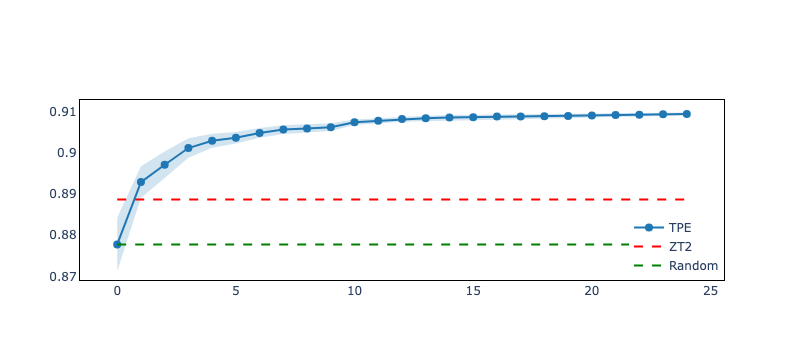

Figure saved to plots/core_ZT_vs_SOTA_Performance_Dataset_917.pdf


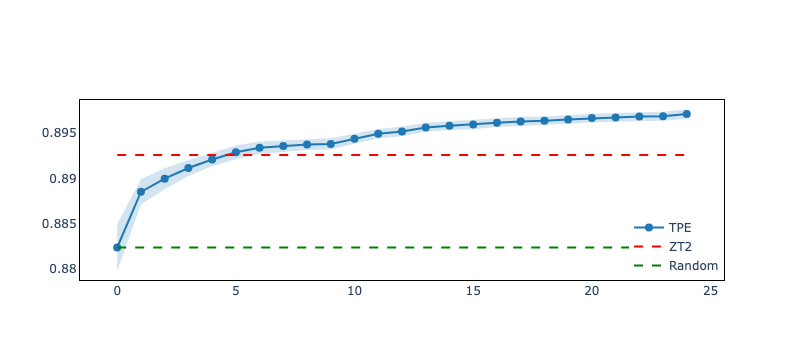

Figure saved to plots/core_ZT_vs_SOTA_Performance_Dataset_1049.pdf


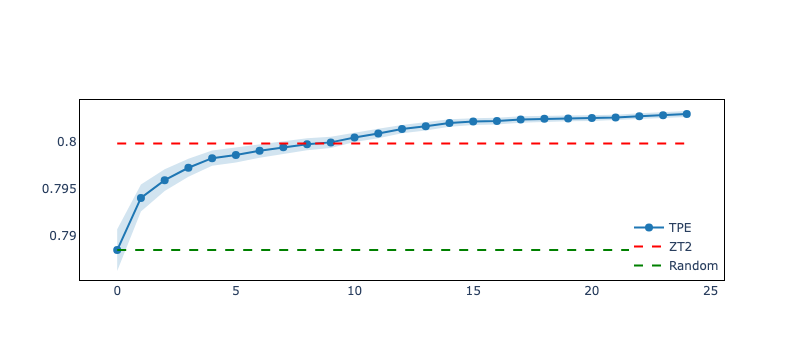

Figure saved to plots/core_ZT_vs_SOTA_Performance_Dataset_1111.pdf


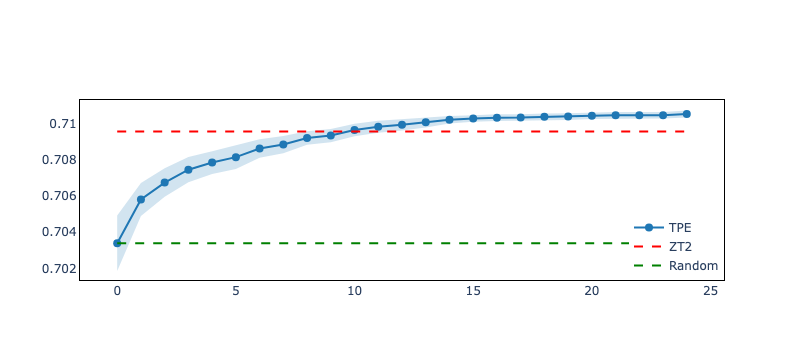

Figure saved to plots/core_ZT_vs_SOTA_Performance_Dataset_1464.pdf


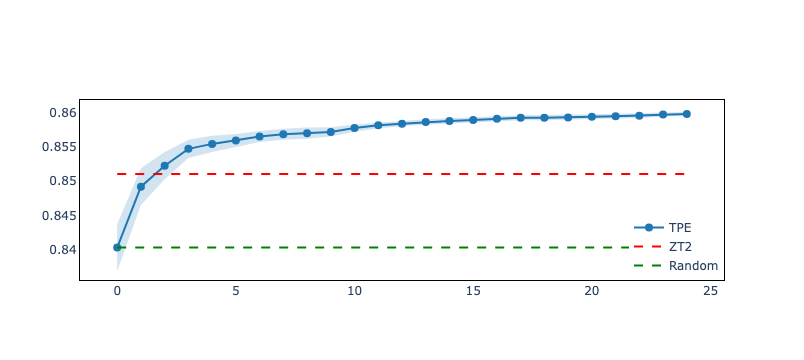

Figure saved to plots/core_ZT_vs_SOTA_Performance_Dataset_1494.pdf


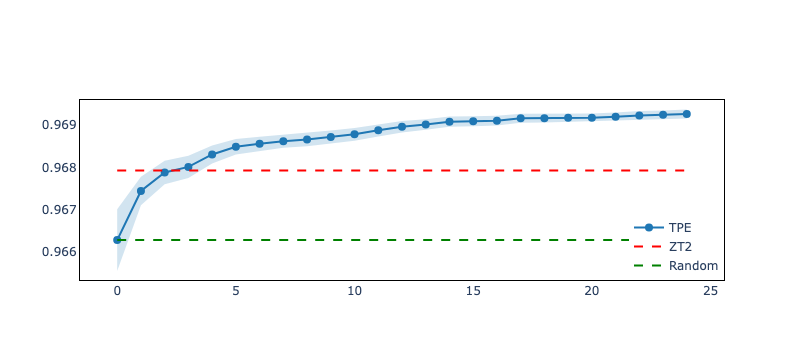

Figure saved to plots/core_ZT_vs_SOTA_Performance_Dataset_1510.pdf


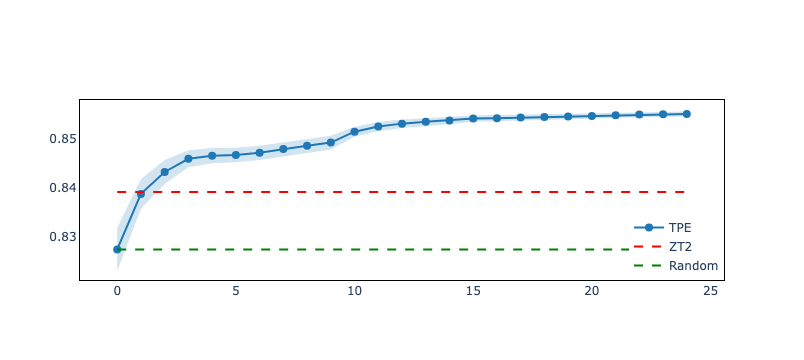

Figure saved to plots/core_ZT_vs_SOTA_Performance_Dataset_1558.pdf


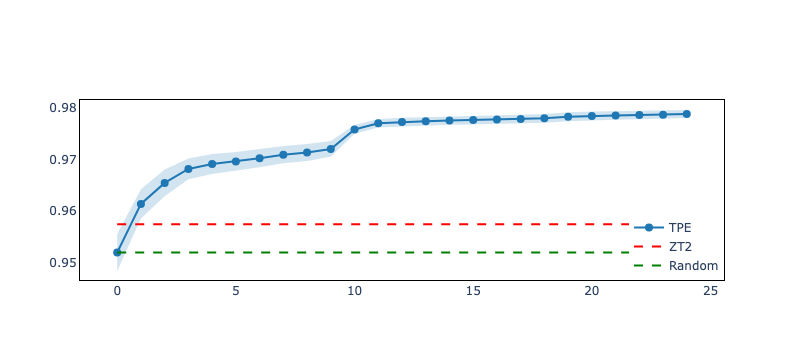

Figure saved to plots/core_ZT_vs_SOTA_Performance_Dataset_4534.pdf


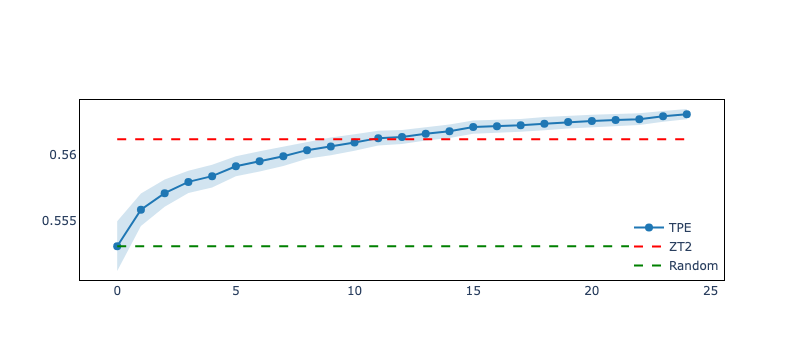

Figure saved to plots/core_ZT_vs_SOTA_Performance_Dataset_23381.pdf


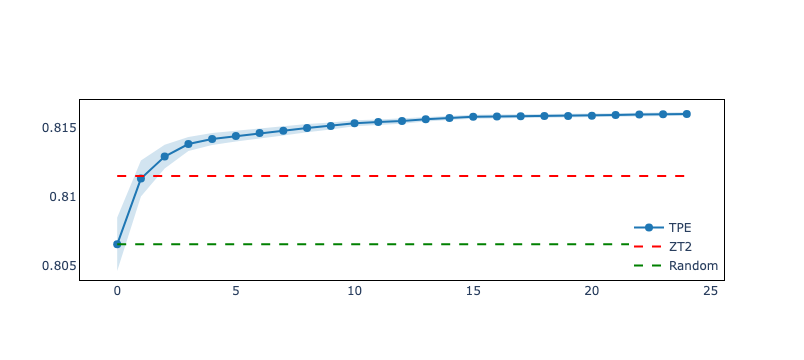

Figure saved to plots/core_ZT_vs_SOTA_Performance_Dataset_40536.pdf


In [42]:
#dataset_id_list = [38, 179, 298, 917, 1049, 1111, 1120, 1128, 1169, 1597, 42206]
dataset_id_list = [917, 1049, 1111, 1464, 1494, 1510, 1558, 4534, 23381, 40536]

for dataset_id in dataset_id_list:    
    plot_hpo_performance(df_kb_optuna_trials_realworld, results_df=results_df
                     , dataset=dataset_id, exclude_default=True
                     , save_file=True, only_increasing=True
                     , plot_all_traces=False, show_confidence_interval=True, remove_headers=True, file_prefix='core')

In [ ]:
#dataset_id_list = [38, 179, 298, 917, 1049, 1111, 1120, 1128, 1169, 1597, 42206]
#dataset_id_list = [917, 1049, 1111, 1464, 1494, 1510, 1558, 4534, 23381, 40536]

#for dataset_id in dataset_id_list:    
#    plot_hpo_performance(df_kb_optuna_trials_realworld, results_df=results_df
#                     , dataset=dataset_id, exclude_default=True
#                     , save_file=True, only_increasing=True
#                     , plot_all_traces=False, show_confidence_interval=True, remove_headers=True, file_prefix=KB_TYPE)

In [9]:
import ast
from scipy.stats import ttest_rel
import pandas as pd

def stats_test(df, column1, column2):
    # Significance Testing:
    # Method: A paired t-test on the performance scores from each approach.
    # This test helps understand if the differences in performance scores are statistically significant.
    print('--- ')
    print(column1, ' vs ', column2)
    
    # Perform paired t-test on each dataset and calculate percentage uplift
    results = []
    for i, row in df.iterrows():
        try:
            # Convert strings representing lists to actual lists
            column1_scores = ast.literal_eval(row[column1]) if isinstance(row[column1], str) else row[column1]
            column2_scores = ast.literal_eval(row[column2]) if isinstance(row[column2], str) else row[column2]
            
            # Ensure the scores are numerical values
            column1_scores = [float(score) for score in column1_scores]
            column2_scores = [float(score) for score in column2_scores]
            
            # Calculate mean of the scores for both columns
            mean_column1 = sum(column1_scores) / len(column1_scores)
            mean_column2 = sum(column2_scores) / len(column2_scores)
            
            # Calculate the t-test for the paired scores
            t_stat, p_value = ttest_rel(column1_scores, column2_scores)
            
            # Calculate percentage uplift
            uplift = ((mean_column1 - mean_column2) / mean_column2) * 100 if mean_column2 != 0 else None
            
            # Append results
            results.append({
                'Dataset': row['Dataset'],
                column1: mean_column1,
                column2: mean_column2,
                'Best Method': column1 if mean_column1 > mean_column2 else column2,
                't_stat': t_stat,
                'p_value': p_value,
                'Significant': p_value < 0.05,
                'Uplift (%)': uplift
            })
        except ValueError as e:
            print(f"Error parsing scores for row {i}: {e}")
            continue

    # Convert results into a DataFrame for display
    sig_test_results_df = pd.DataFrame(results)
    
    # Display the results
    display(sig_test_results_df)
    
    return sig_test_results_df

# Example usage
#df = results_df
#sig_test_results_df = stats_test(df, column1="ZeroTune_seed_scores", column2="Default_seed_scores")


In [ ]:
df = results_df
retrain = False

sig_test_results_df = stats_test(df, column1="ZeroTune_seed_scores", column2="Random_seed_scores")
path = f'{output_root}real_world_signficant_results_random_retrain_{retrain}_{KB_TYPE}_kb.csv'
print(f'Saved to: {path}')
#sig_test_results_df.to_csv(path, index=False)

for hpo_iteration in(1, 2, 5, 10, 20):
    print(hpo_iteration)
    sig_test_results_df = stats_test(df, column1="ZeroTune_seed_scores", column2=f"SOTA_n{hpo_iteration}_seed_scores")
    path = f'{output_root}real_world_signficant_results_SOTA_N{hpo_iteration}_retrain_{retrain}_{KB_TYPE}_kb.csv'
    print(f'Saved to: {path}')
 #   sig_test_results_df.to_csv(path, index=False)

In [ ]:
df = results_df

sig_test_results_df = stats_test(df, column1="ZeroTune_seed_scores", column2="Random_seed_scores")
path = f'{output_root}real_world_signficant_results_random_retrain_{retrain}_{KB_TYPE}_kb.csv'
print(f'Saved to: {path}')
sig_test_results_df.to_csv(path, index=False)

for hpo_iteration in(1, 2, 5, 10, 20):
    print(hpo_iteration)
    sig_test_results_df = stats_test(df, column1="ZeroTune_seed_scores", column2=f"SOTA_n{hpo_iteration}_seed_scores")
    path = f'{output_root}real_world_signficant_results_SOTA_N{hpo_iteration}_retrain_{retrain}_{KB_TYPE}_kb.csv'
    print(f'Saved to: {path}')
    sig_test_results_df.to_csv(path, index=False)

In [ ]:
# Load saved results
sig_test_results_df_random = pd.read_csv(f'{output_root}real_world_signficant_results_random_retrain_{retrain}_{KB_TYPE}_kb.csv')
sig_test_results_df_SOTA_N1 = pd.read_csv(f'{output_root}real_world_signficant_results_SOTA_N1_retrain_{retrain}_{KB_TYPE}_kb.csv')
sig_test_results_df_SOTA_N5 = pd.read_csv(f'{output_root}real_world_signficant_results_SOTA_N5_retrain_{retrain}_{KB_TYPE}_kb.csv')
sig_test_results_df_SOTA_N10 = pd.read_csv(f'{output_root}real_world_signficant_results_SOTA_N10_retrain_{retrain}_{KB_TYPE}_kb.csv')
sig_test_results_df_SOTA_N20 = pd.read_csv(f'{output_root}real_world_signficant_results_SOTA_N20_retrain_{retrain}_{KB_TYPE}_kb.csv')

In [ ]:
sig_test_results_df_random.head(1)

In [10]:
def calculate_best_and_significant_percentages(df):
    """
    This function takes a dataframe and calculates:
    1. How often each method is listed as the best (Best Percentage).
    2. How often each method is listed as the best with significant results (Significant Percentage).
    
    Parameters:
    df (pandas.DataFrame): Input dataframe with 'Best Method' and 'Significant' columns.
    
    Returns:
    pandas.DataFrame: A dataframe with HPO method, total count, significant count, 
                      best percentage, and significant percentage.
    """
    
    # 1. Extract possible method names from the column headers (excluding 'Dataset', 'Best Method', 'Significant', etc.)
    possible_methods = [col for col in df.columns if '_seed_scores' in col]

    # 2. Calculate Total Count (how often each method is listed as the best)
    best_method_counts = df['Best Method'].value_counts().reset_index()
    best_method_counts.columns = ['HPO Method', 'Total Count']

    # 3. Calculate the total number of rows (datasets)
    total_rows = len(df)

    # 4. Calculate how many times each method was the best with a significant result
    significant_counts = df[df['Significant'] == True].groupby('Best Method').size().reset_index(name='Significant Count')

    # 5. Merge total counts and significant counts into one table
    result = pd.merge(best_method_counts, significant_counts, left_on='HPO Method', right_on='Best Method', how='outer')

    # 6. Drop redundant 'Best Method' column from the merge
    result = result.drop(columns=['Best Method'])

    # 7. Ensure all possible methods (extracted from column headers) are included
    all_methods_df = pd.DataFrame({'HPO Method': possible_methods})
    result = pd.merge(all_methods_df, result, on='HPO Method', how='left')

    # 8. Replace NaN values with 0 for 'Total Count' and 'Significant Count'
    result['Total Count'] = result['Total Count'].fillna(0)
    result['Significant Count'] = result['Significant Count'].fillna(0)

    # 9. Calculate the percentage each method is the best
    result['Best Percentage'] = (result['Total Count'] / total_rows) * 100

    # 10. Calculate the percentage each method is significantly the best
    result['Significant Percentage'] = (result['Significant Count'] / total_rows) * 100
    
    display(result)
    return result

# Example usage:
# result = calculate_best_and_significant_percentages(df)


In [ ]:
#sig_test_results_df_SOTA_N5.head(10)

In [ ]:
print(f'Knowledge Base: {KB_TYPE}')
calculate_best_and_significant_percentages(sig_test_results_df_random)
calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N1)
calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N5)
calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N10)
calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N20)

In [ ]:
calculate_best_and_significant_percentages(sig_test_results_df_random)
calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N1)
calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N5)
calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N10)
calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N20)

In [ ]:
def evaluate_model(X, y, model_name, hyperparams, random_seed=42, n_folds=3, n_seeds=20):
    seed_scores = []

    for i in range(n_seeds):
        seed = random_seed + i
        if model_name == "DecisionTreeClassifier2Param" or model_name == "DecisionTreeClassifier4Param":
            model = DecisionTreeClassifier(random_state=seed, **hyperparams)
        elif model_name == "RandomForestClassifier":
            model = RandomForestClassifier(random_state=seed, **hyperparams)
        elif model_name == "XGBClassifier":
            model = XGBClassifier(random_state=seed, **hyperparams)
        
        cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
        scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
        seed_scores.append(np.mean(scores))

    final_score = np.mean(seed_scores)
    return final_score, seed_scores

print(f'ZeroTune Knowledge Base: {KB_TYPE}')

retrain = False

N_SEEDS = 50
df_kb_optuna_trials['rank'] = df_kb_optuna_trials.groupby('Dataset')['value'].rank(method='dense', ascending=False)
df = pd.merge(df_kb_optuna_trials, df_dataset_features, on='Dataset', how='inner')
print(f'Number of unique datasets used for model training: {len(df.Dataset.unique())}')

dataset_id_list = [
    31, 38, 44, 52, 151, 179, 298, 846, 917,
    1049, 1053, 1111, 1112, 1120, 1128, 1220, 1464,
    1494, 1510, 1558, 4534, 23381, 40536, 40900, 45038
]
dataset_id = 917

test_dataset_list = [917, 1049, 1111, 1464, 1494, 1510, 1558, 4534, 23381, 40536]
dataset_id_list = test_dataset_list

# Define features and targets
param_config = ml_config['param_config']
# dataset_features = ['n_samples', 'n_features', 'n_highly_target_corr']
targets = ['params_max_depth', 'params_max_features', 'params_min_samples_leaf', 'params_min_samples_split']

# Prepare a list to store the results
results = []
optuna_trials_df_list = []


# Prepare features for the left-out dataset
new_dataset_df = df[df['Dataset'] == dataset_id]
dataset_parameters = new_dataset_df[dataset_features].head(1)

# Calculate best SOTA results at increasing iterations on this dataset
df_sota_avg_best = calculate_average_best_performance(new_dataset_df)

hpo_iterations = [0, 1, 2, 5, 10, 20]
sota_performance, sota_seed_scores = extract_performance_at_iterations(df_sota_avg_best, hpo_iterations)

# Predict ZeroTune hyperparameters
zerotune_params_rel = predict_hyperparameters(model, dataset_parameters, targets)
zerotune_params_rel = remove_param_prefix(predicted_hyperparams_rel)
zerotune_params = _relative2absolute_dict(
    param_config, dataset_parameters, zerotune_params_rel
)

print(zerotune_params) # The best hyperparameters predicted by ZeroTune

# Evaluate ZeroTune performance
dataset_df, target_name, dataset_name = fetch_open_ml_data(dataset_id)
X, y = prepare_data(dataset_df, target_name)
perf, all_scores = evaluate_model(
    X, y, ml_config['name'], predicted_hyperparams, random_seed=42, n_seeds=N_SEEDS
)
print(perf) # avg of all_scores
print(all_scores)

#ZeroTune Knowledge Base: real_world
#Number of unique datasets used for model training: 25
#{'max_depth': 620, 'max_features': 0.7218697031860128, 'min_samples_leaf': 0.04616914329529813, 'min_samples_split': 0.05267681139007818}
#Dataset name: fri_c1_1000_25
#0.8886526029158479
#[0.8836173629437832, 0.8858405086838338, 0.8961153759973035, 0.8924850492252027, 0.8587451818542791, 0.9108892407406698, 0.8907538522822595, 0.8953088672394179, 0.9074007931188133, 0.8927384846476865, 0.9022047684800386, 0.9120499286933584, 0.9017751012784124, 0.8895037118394561, 0.88372564753708, 0.8868830970063978, 0.9036176550009767, 0.9056184462684985, 0.8787183429153629, 0.8529247852182674, 0.826235066780553, 0.9070193632323295, 0.8872721874094301, 0.8865736041581284, 0.8841882310207511, 0.8726619864102436, 0.9024775945850362, 0.8898681449548477, 0.9158511807409507, 0.888441653037331, 0.8872126987106074, 0.9092074780685794, 0.8909188326777208, 0.9073935714860254, 0.8746443046612967, 0.8860923082668464, 0.8482077822549242, 0.8926387782369831, 0.8752162898969278, 0.9073303323259755, 0.8815330241676529, 0.8865143947489713, 0.8896582388217104, 0.8872548315516249, 0.873195230179371, 0.8826036212538478, 0.8997021734800578, 0.8961141790415929, 0.9017508828745323, 0.8639359797864504]

In [9]:
import optuna
from optuna.trial import Trial


def _optuna_objective(trial: Trial, X, y, param_config, meta_params, dataset_meta_params, random_seed=42, n_folds=3, n_seeds_eval=50):
    
    # Generate hyperparameters based on the trial
    hyperparams = {}
    for param, config in param_config.items():
        if 'percentage_splits' in config:
            min_value = min(config['percentage_splits'])
            max_value = max(config['percentage_splits'])
            hyperparams[param] = trial.suggest_uniform(param, min_value, max_value)
        # Add other parameter types (e.g., suggest_int, suggest_loguniform) as needed

    predicted_hyperparams = _relative2absolute_dict(param_config, dataset_meta_params, hyperparams)
    
    score, _ = evaluate_model(X, y, "DecisionTreeClassifier4Param", predicted_hyperparams, random_seed, n_folds, n_seeds_eval)
    return score

def optuna_perf_wrapper_inc_seeds(X, y, meta_params, zerotune_params=None, n_trials=100, n_seeds=1, seed=None):
    all_dataset_meta_params = calculate_dataset_meta_parameters(X, y)
    dataset_meta_params = {key: all_dataset_meta_params[key] for key in meta_params}
    dataset_meta_params_inc_dependencies = {key: all_dataset_meta_params[key] for key in ['n_samples']}
    dataset_meta_params_inc_dependencies.update(dataset_meta_params)
    
    results = []
    best_perfs = []
    
    # Adjust the seeds to process
    seeds_to_process = [seed] if seed is not None else range(n_seeds)
    
    for seed_value in seeds_to_process:
        study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed_value))
        
        if zerotune_params:
            # Enqueue the ZeroTune hyperparameters trial
            study.enqueue_trial(zerotune_params)
        
        study.optimize(lambda trial: _optuna_objective(trial, X, y, ml_config["param_config"], meta_params, dataset_meta_params_inc_dependencies, n_seeds_eval=50), n_trials=n_trials)
        
        best_hyperparams = study.best_params
        best_perf = study.best_value
        
        # Get trials DataFrame and add seed column
        df_trials = study.trials_dataframe()
        df_trials['seed'] = seed_value
        
        result = {
            "best_hyperparams": best_hyperparams,
            "best_perf": best_perf,
            "df_trials": df_trials
        }
        results.append(result)
        best_perfs.append(best_perf)
    
    # Calculate the average of best_perf across all seeds
    average_best_perf = sum(best_perfs) / len(best_perfs)
    
    # Combine all results into a single DataFrame for analysis
    combined_trials_df = pd.concat([result['df_trials'] for result in results], ignore_index=True)
    
    return {
        "all_results": results,
        "average_best_perf": average_best_perf,
        "n_seed_scores": best_perfs,
        "combined_trials_df": combined_trials_df
    }

#optuna_output = optuna_perf_wrapper_inc_seeds(
#    X, y, dataset_parameters, zerotune_params=zerotune_params,
#    n_trials=5, n_seeds=N_SEEDS
#)


#print(optuna_output["average_best_perf"])
#print(optuna_output["n_seed_scores"])

# 0.8886526029158476
# [0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479, 0.8886526029158479]

## Now lets look at warm starting Optuna with ZeroTune

In [10]:
import os
import pandas as pd
from tqdm import tqdm

# Assuming output_root and other necessary variables are defined
checkpoint_dir = os.path.join(output_root, 'checkpoint_warmstart_v2')
os.makedirs(checkpoint_dir, exist_ok=True)

print(f'ZeroTune Knowledge Base: {KB_TYPE}')

retrain = False

N_SEEDS = 50
df_kb_optuna_trials['rank'] = df_kb_optuna_trials.groupby('Dataset')['value'].rank(method='dense', ascending=False)
df = pd.merge(df_kb_optuna_trials, df_dataset_features, on='Dataset', how='inner')
print(f'Number of unique datasets used for model training: {len(df.Dataset.unique())}')

dataset_id_list = [
    31, 38, 44, 52, 151, 179, 298, 846, 917,
    1049, 1053, 1111, 1112, 1120, 1128, 1220, 1464,
    1494, 1510, 1558, 4534, 23381, 40536, 40900, 45038
]

test_dataset_list = [917, 1049, 1111, 1464, 1494, 1510, 1558, 4534, 23381, 40536]
dataset_id_list = test_dataset_list
#dataset_id_list = [1049, 1111]

# Define features and targets
param_config = ml_config['param_config']
# dataset_features = ['n_samples', 'n_features', 'n_highly_target_corr']
targets = ['params_max_depth', 'params_max_features', 'params_min_samples_leaf', 'params_min_samples_split']

# Prepare a list to store the results
results = []
optuna_trials_df_list = []

# Iterate over each dataset id, leaving one out
for dataset_id in tqdm(dataset_id_list, desc="Benchmark on real-world datasets"):

    # Define file paths for checkpointing
    optuna_trials_file = os.path.join(checkpoint_dir, f'dataset_{dataset_id}_optuna_trials.pkl')
    result_file = os.path.join(checkpoint_dir, f'dataset_{dataset_id}_result.pkl')

    # Check if results for this dataset already exist
    if os.path.exists(result_file) and os.path.exists(optuna_trials_file):
        print(f"Dataset {dataset_id} already processed. Loading results.")
        # Load existing results
        result = pd.read_pickle(result_file)
        results.append(result)
        optuna_trials = pd.read_pickle(optuna_trials_file)
        optuna_trials_df_list.append(optuna_trials)
        continue

    # Retrain the ZeroTune model if needed
    if retrain:
        train_df = df[df['Dataset'] != dataset_id]
        train_df = train_df[train_df['rank'] == 1]
        print(f'Number of data points used for model training: {len(train_df)}')
        print(f'Number of unique datasets used for model training: {len(train_df.Dataset.unique())}')

        model, error_score = train_zeroshot_hpo(
            train_df, dataset_features, targets, condition_column='Dataset'
        )

    # Prepare features for the left-out dataset
    new_dataset_df = df[df['Dataset'] == dataset_id]
    dataset_parameters = new_dataset_df[dataset_features].head(1)

    # Calculate best SOTA results at increasing iterations on this dataset
    df_sota_avg_best = calculate_average_best_performance(new_dataset_df)

    hpo_iterations = [0, 1, 2, 5, 10, 20]
    sota_performance, sota_seed_scores = extract_performance_at_iterations(df_sota_avg_best, hpo_iterations)

    # Predict ZeroTune hyperparameters
    predicted_hyperparams_rel = predict_hyperparameters(model, dataset_parameters, targets)
    predicted_hyperparams_rel = remove_param_prefix(predicted_hyperparams_rel)
    predicted_hyperparams = _relative2absolute_dict(
        param_config, dataset_parameters, predicted_hyperparams_rel
    )

    # Evaluate ZeroTune performance
    dataset_df, target_name, dataset_name = fetch_open_ml_data(dataset_id)
    X, y = prepare_data(dataset_df, target_name)
    perf, all_scores = evaluate_model(
        X, y, ml_config['name'], predicted_hyperparams, random_seed=42, n_seeds=N_SEEDS
    )

    # ZT Warm Start SOTA
    # Process seeds individually with checkpointing
    per_seed_results = []
    for seed in range(N_SEEDS):
        seed_trials_file = os.path.join(
            checkpoint_dir, f'dataset_{dataset_id}_seed_{seed}_optuna_trials.pkl'
        )
        if os.path.exists(seed_trials_file):
            print(f"Dataset {dataset_id}, Seed {seed} already processed. Loading results.")
            seed_trials = pd.read_pickle(seed_trials_file)
        else:
            # Run Optuna HPO for the current seed
            optuna_output = optuna_perf_wrapper_inc_seeds(
                X, y, dataset_parameters, zerotune_params=predicted_hyperparams,
                n_trials=25, n_seeds=1, seed=seed
            )
            seed_trials = optuna_output["combined_trials_df"]
            seed_trials['Dataset'] = dataset_id
            seed_trials['Seed'] = seed
            # Save individual seed results
            pd.to_pickle(seed_trials, seed_trials_file)
        per_seed_results.append(seed_trials)

    # Combine seed results for the current dataset
    optuna_trials = pd.concat(per_seed_results, ignore_index=True)
    optuna_trials_df_list.append(optuna_trials)

    # Save combined Optuna trials for the dataset
    pd.to_pickle(optuna_trials, optuna_trials_file)

    # Calculate best SOTA WS results at increasing iterations on this dataset
    df_sota_avg_best_ws = calculate_average_best_performance(optuna_trials)
    sota_ws_performance, sota_ws_seed_scores = extract_performance_at_iterations(
        df_sota_avg_best_ws, hpo_iterations, prefix="ZT"
    )

    # Store the benchmark results
    result = {
        'Dataset': dataset_id,
        'ZeroTune_predicted_hps': predicted_hyperparams_rel,
        'ZeroTune_performance': perf,
        'ZeroTune_seed_scores': all_scores,
    }
    result.update(sota_performance)
    result.update(sota_seed_scores)
    result.update(sota_ws_performance)
    result.update(sota_ws_seed_scores)

    results.append(result)

    # Save the benchmark result for this dataset
    pd.to_pickle(result, result_file)

# Convert results to DataFrame for better analysis
results_df = pd.DataFrame(results)

# Combine all Optuna trials
optuna_trials_all = pd.concat(optuna_trials_df_list, ignore_index=True)

# Save the combined results and Optuna trials
os.makedirs(output_root, exist_ok=True)

results_df.to_pickle(os.path.join(output_root, f'ZT_WS_benchmark_results_retrain_{retrain}_{KB_TYPE}_kb_v2.pkl'))
optuna_trials_all.to_pickle(os.path.join(output_root, f'ZT_WS_optuna_trials_all_retrain_{retrain}_{KB_TYPE}_kb_v2.pkl'))

# Optionally, save results to CSV
results_df.to_csv(os.path.join(output_root, f'ZT_WS_benchmark_results_retrain_{retrain}_{KB_TYPE}_kb_v2.csv'), index=False)
optuna_trials_all.to_csv(os.path.join(output_root, f'ZT_WS_optuna_trials_all_retrain_{retrain}_{KB_TYPE}_kb_v2.csv'), index=False)

ZeroTune Knowledge Base: real_world
Number of unique datasets used for model training: 25


Benchmark on real-world datasets:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset 917 already processed. Loading results.
Dataset 1049 already processed. Loading results.
Dataset 1111 already processed. Loading results.
Dataset 1464 already processed. Loading results.
Dataset 1494 already processed. Loading results.
Dataset 1510 already processed. Loading results.
Dataset 1558 already processed. Loading results.
Dataset 4534 already processed. Loading results.
Dataset 23381 already processed. Loading results.
Dataset name: SpeedDating
Dataset 40536, Seed 0 already processed. Loading results.
Dataset 40536, Seed 1 already processed. Loading results.
Dataset 40536, Seed 2 already processed. Loading results.
Dataset 40536, Seed 3 already processed. Loading results.
Dataset 40536, Seed 4 already processed. Loading results.
Dataset 40536, Seed 5 already processed. Loading results.
Dataset 40536, Seed 6 already processed. Loading results.
Dataset 40536, Seed 7 already processed. Loading results.
Dataset 40536, Seed 8 already processed. Loading results.
Dataset 405

Benchmark on real-world datasets: 100%|██████████| 10/10 [56:46<00:00, 340.69s/it]


In [ ]:
#results_df.to_csv(f"{output_root}ZT_warmstart_benchmark_results.csv", index=False)
#optuna_trials_all.to_csv(f"{output_root}ZT_warmstart_optuna_trials_all.csv", index=False)

In [ ]:
optuna_trials_all.head()

In [11]:
import colorsys

def generate_shades(base_color, num_shades=5, alpha=0.3):
    """
    Generate a list of RGBA color variations around a given hex color.
    Each shade will have the specified alpha (transparency).
    
    Parameters:
    - base_color (str): A hex color code, e.g. "#1f77b4".
    - num_shades (int): How many shades to generate.
    - alpha (float): Transparency level (0.0 is fully transparent, 1.0 is fully opaque).
    
    Returns:
    - List of RGBA color strings, e.g. "rgba(r, g, b, alpha)".
    """
    # Remove '#' if present
    color_str = base_color.lstrip('#')
    # Convert to integer RGB
    r, g, b = int(color_str[0:2], 16), int(color_str[2:4], 16), int(color_str[4:6], 16)
    
    # Convert from RGB [0..255] to HLS [0..1]
    h, l, s = colorsys.rgb_to_hls(r/255.0, g/255.0, b/255.0)
    
    # We can interpolate the lightness between 50% and 100% of the original as an example
    min_lightness_factor = 0.5
    max_lightness_factor = 1.0
    
    shades = []
    if num_shades < 2:
        # If asked for only 1 shade, just return the base color in RGBA form
        return [f"rgba({r},{g},{b},{alpha})"]
    
    for i in range(num_shades):
        ratio = i / (num_shades - 1)
        # new lightness is a linear interpolation
        new_l = l * (min_lightness_factor + (max_lightness_factor - min_lightness_factor) * ratio)
        
        # Convert back to RGB
        r_new, g_new, b_new = colorsys.hls_to_rgb(h, new_l, s)
        r_final = int(r_new * 255)
        g_final = int(g_new * 255)
        b_final = int(b_new * 255)
        
        # Create an RGBA string with specified alpha
        rgba_color = f"rgba({r_final}, {g_final}, {b_final}, {alpha})"
        shades.append(rgba_color)
    
    return shades


In [38]:
import plotly.graph_objects as go
from scipy.stats import t

def compute_avg_best_so_far(df, only_increasing=True):
    # Sort by seed and number
    df_sorted = df.sort_values(['seed', 'number']).copy()
    
    # For each seed, compute the running best (cummax) of 'value'
    df_sorted['cummax_value'] = df_sorted.groupby('seed')['value'].cummax()
    
    # For each iteration, compute mean, std, count of seed-level best-so-far
    df_stats = df_sorted.groupby('number')['cummax_value'].agg(['mean', 'std', 'count']).reset_index()
    
    # Standard error of the mean
    df_stats['sem'] = df_stats['std'] / df_stats['count']**0.5
    
    # Optionally ensure the final reported column is non-decreasing across iterations
    # The column 'mean' is already the "average best-so-far at each iteration".
    # If you want to make sure it never decreases, you can do:
    if only_increasing:
        df_stats['mean_cummax'] = df_stats['mean'].cummax()
    else:
        df_stats['mean_cummax'] = df_stats['mean']
    
    return df_stats


def plot_hpo_performance(optuna_trials_1, optuna_trials_2=None, results_df=None, dataset=None, exclude_default=False, 
                         save_file=False, only_increasing=False, plot_all_traces=False, show_confidence_interval=False, 
                         file_prefix="", remove_headers=False, max_iter=25):
    """
    Plots the performance changes across iterations for the state-of-the-art HPO method,
    with optional comparison between two optuna_trials DataFrames, and the performances
    for the ZeroTune, Random, and optionally Default methods.

    Parameters:
    - optuna_trials_1 (pd.DataFrame): DataFrame containing the first set of state-of-the-art HPO results.
    - optuna_trials_2 (pd.DataFrame, optional): DataFrame containing the second set of HPO results for comparison. Default is None.
    - results_df (pd.DataFrame, optional): DataFrame containing the challenger HPO approaches. Default is None.
    - dataset (int, optional): The dataset identifier to filter the dataframes. Default is None.
    - exclude_default (bool): Flag to exclude Default performance from the plot. Default is False.
    - save_file (bool): Flag to save the plot as a PDF file. Default is False.
    - only_increasing (bool): Flag to show only increasing or flat performance across iterations. Default is False.
    - plot_all_traces (bool): Flag to plot all trace lines for each seed. Default is False.
    - show_confidence_interval (bool): Flag to show confidence intervals for the SOTA method. Default is False.
    - file_prefix (str): Prefix for the saved file name. Default is "".
    - remove_headers (bool): Option to remove the plot title, x-axis title, and y-axis title. Default is False.
    - max_iter (int): Option to limit the number of HPO iterations to plot
    """
    
    # Filter the dataframes based on the Dataset column if dataset is provided
    df_sota_trials_1_filtered = optuna_trials_1[
        (optuna_trials_1['Dataset'] == dataset) & (optuna_trials_1['number'] <= max_iter)
    ] if dataset else optuna_trials_1[optuna_trials_1['number'] <= max_iter].copy()
    
    df_sota_trials_2_filtered = optuna_trials_2[
        (optuna_trials_2['Dataset'] == dataset) & (optuna_trials_2['number'] <= max_iter)
    ] if dataset else optuna_trials_2[optuna_trials_2['number'] <= max_iter].copy()
        
    df_results_filtered = results_df[results_df['Dataset'] == dataset] if results_df is not None and dataset else None

    # Check if the filtered dataframes are not empty
    if not df_sota_trials_1_filtered.empty:
        # Create a Plotly figure
        fig = go.Figure()

        # Define a base color for the first dataframe
        base_color_1 = "#1f77b4"  # Standard Plotly blue

        # Get unique seeds for the first dataset
        unique_seeds_1 = sorted(df_sota_trials_1_filtered['seed'].unique())

        # Optionally plot all traces for each seed in the first dataset
        if plot_all_traces:
            shades_1 = generate_shades(base_color_1, len(unique_seeds_1))

            for i, seed in enumerate(unique_seeds_1):
                df_seed_filtered = df_sota_trials_1_filtered[df_sota_trials_1_filtered['seed'] == seed]
                color = shades_1[i]

                fig.add_trace(go.Scatter(
                    x=df_seed_filtered["number"],
                    y=df_seed_filtered["value"],
                    mode='lines',
                    name=f'Seed 1 - {seed}',
                    line=dict(color=color, width=1),
                    showlegend=False
                ))

        df_stats_1 = compute_avg_best_so_far(df_sota_trials_1_filtered, only_increasing=only_increasing)

        # Optionally add confidence intervals for the first DataFrame
        if show_confidence_interval:
            confidence_level = 0.95
            degrees_freedom_1 = df_stats_1['count'] - 1
            t_critical_1 = t.ppf((1 + confidence_level) / 2, degrees_freedom_1)
            df_stats_1['ci'] = t_critical_1 * df_stats_1['sem']

            fig.add_trace(go.Scatter(
                x=pd.concat([df_stats_1["number"], df_stats_1["number"][::-1]]),
                y=pd.concat([df_stats_1['mean_cummax'] + df_stats_1['ci'], (df_stats_1['mean_cummax'] - df_stats_1['ci'])[::-1]]),
                fill='toself',
                fillcolor='rgba(31, 119, 180, 0.2)',
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo="skip",
                showlegend=False
            ))

        # Plot the average SOTA performance for the first DataFrame
        fig.add_trace(go.Scatter(
            x=df_stats_1["number"],
            y=df_stats_1["mean_cummax"],
            mode='lines+markers',
            name='TPE',
            line=dict(color=base_color_1, width=2),
            marker=dict(size=8)
        ))

        # If the second DataFrame is provided, plot it
        if df_sota_trials_2_filtered is not None and not df_sota_trials_2_filtered.empty:
            base_color_2 = "#ff7f0e"  # Standard Plotly orange
            unique_seeds_2 = sorted(df_sota_trials_2_filtered['seed'].unique())

            if plot_all_traces:
                shades_2 = generate_shades(base_color_2, len(unique_seeds_2))

                for i, seed in enumerate(unique_seeds_2):
                    df_seed_filtered = df_sota_trials_2_filtered[df_sota_trials_2_filtered['seed'] == seed]
                    color = shades_2[i]

                    fig.add_trace(go.Scatter(
                        x=df_seed_filtered["number"],
                        y=df_seed_filtered["value"],
                        mode='lines',
                        name=f'Seed 2 - {seed}',
                        line=dict(color=color, width=1),
                        showlegend=False
                    ))

            df_stats_2 = compute_avg_best_so_far(df_sota_trials_2_filtered, only_increasing=only_increasing)
            
            if show_confidence_interval:
                degrees_freedom_2 = df_stats_2['count'] - 1
                t_critical_2 = t.ppf((1 + confidence_level) / 2, degrees_freedom_2)
                df_stats_2['ci'] = t_critical_2 * df_stats_2['sem']

                fig.add_trace(go.Scatter(
                    x=pd.concat([df_stats_2["number"], df_stats_2["number"][::-1]]),
                    y=pd.concat([df_stats_2['mean_cummax'] + df_stats_2['ci'], (df_stats_2['mean_cummax'] - df_stats_2['ci'])[::-1]]),
                    fill='toself',
                    fillcolor='rgba(255,127,14, 0.2)',  # Semi-transparent orange
                    line=dict(color='rgba(255,255,255,0)'),
                    hoverinfo="skip",
                    showlegend=False
                ))

            # Plot the average SOTA performance for the second DataFrame
            fig.add_trace(go.Scatter(
                x=df_stats_2["number"],
                y=df_stats_2["mean_cummax"],
                mode='lines+markers',
                name='ZT2 + TPE',
                line=dict(color=base_color_2, width=2),
                marker=dict(size=8)
            ))

        # If the results_df is provided, plot ZeroTune, Random, and Default performances
        if df_results_filtered is not None and not df_results_filtered.empty:
            x_range = [df_stats_1["number"].min(), df_stats_1["number"].max()] # just to get number of iterations fo the x axis

            zero_tune_perf = df_results_filtered['ZeroTune_performance'].values[0]
            fig.add_trace(go.Scatter(
                x=x_range, 
                y=[zero_tune_perf, zero_tune_perf],
                mode='lines',
                name='ZT2',
                line=dict(color='red', width=2, dash='dash'),
                showlegend=True
            ))

            random_perf = df_results_filtered['Random_performance'].values[0]
            fig.add_trace(go.Scatter(
                x=x_range,
                y=[random_perf, random_perf],
                mode='lines',
                name='Random',
                line=dict(color='green', width=2, dash='dash'),
                showlegend=True
            ))

            if not exclude_default:
                default_perf = df_results_filtered['Default_performance'].values[0]
                fig.add_trace(go.Scatter(
                    x=x_range,
                    y=[default_perf, default_perf],
                    mode='lines',
                    name='Default',
                    line=dict(color='orange', width=2, dash='dash'),
                    showlegend=True
                ))

        fig.update_layout(
        title=None if remove_headers else f'SOTA Performance Across Iterations<br>Dataset: {dataset}',
        xaxis_title='Iteration Number',  # Keep x-axis title
        yaxis_title='Performance Value (AUC)',  # Keep y-axis title
        showlegend=True,
        plot_bgcolor='white',
        paper_bgcolor='white',
        legend=dict(
            x=1,
            y=0,
            xanchor='right',
            yanchor='bottom'
        )
        )
        
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

        # Show the figure
        fig.show()

        if save_file:
            filename = f"{file_prefix}_ZT_WS_SOTA_vs_SOTA_Performance_Dataset_{dataset}"
            fig.write_image(f"plots/{filename}.pdf")
            print(f"Figure saved to plots/{filename}.pdf")
    else:
        print(f"No data found for Dataset {dataset}")

In [13]:
# checkpoint restart

retrain = False
KB_TYPE = 'real_world'

df_zt_ws_optuna_trials = pd.read_csv(os.path.join(output_root, f'ZT_WS_optuna_trials_all_retrain_{retrain}_{KB_TYPE}_kb_v2.csv'))
df_kb_optuna_trials = pd.read_csv(os.path.join(output_root, f'realworld_kb_optuna_trials_all.csv'))

ws_results_df = pd.read_csv(f"{output_root}ZT_WS_benchmark_results_retrain_{retrain}_{KB_TYPE}_kb_v2.csv")

# Overwrite the Random_seed_scores column with SOTA_n0_seed_scores
ws_results_df['Random_seed_scores'] = ws_results_df['_SOTA_n0_seed_scores_']
ws_results_df['Random_performance'] = ws_results_df['SOTA_n0_performance']

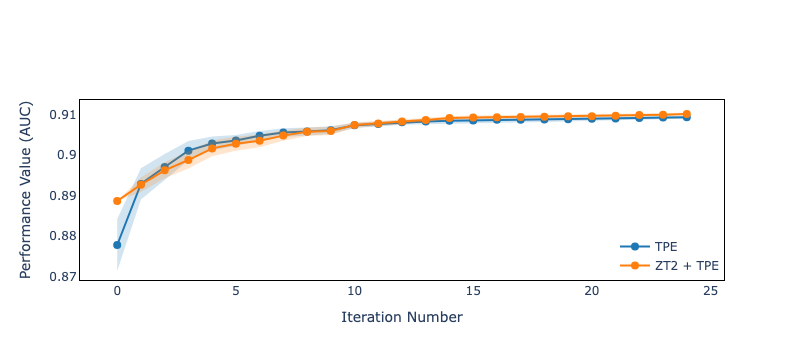

Figure saved to plots/core_ZT_WS_SOTA_vs_SOTA_Performance_Dataset_917.pdf


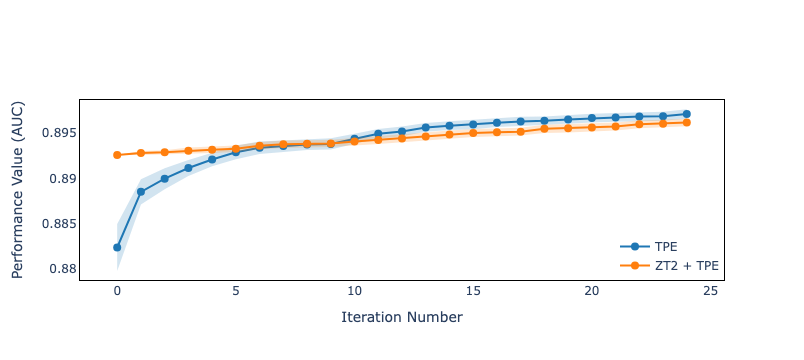

Figure saved to plots/core_ZT_WS_SOTA_vs_SOTA_Performance_Dataset_1049.pdf


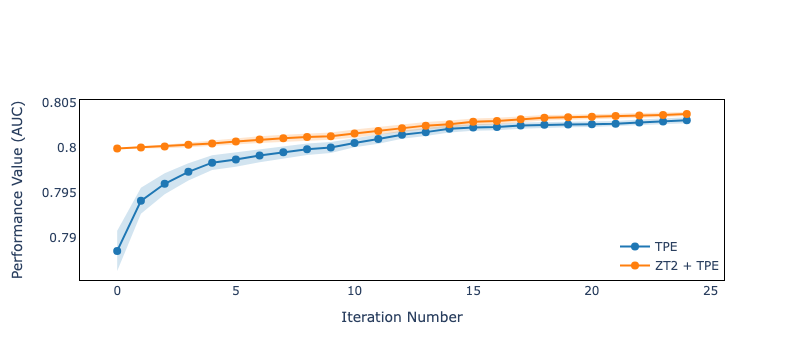

Figure saved to plots/core_ZT_WS_SOTA_vs_SOTA_Performance_Dataset_1111.pdf


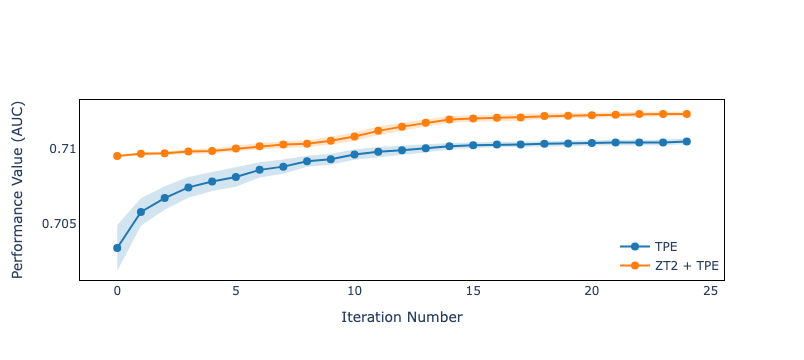

Figure saved to plots/core_ZT_WS_SOTA_vs_SOTA_Performance_Dataset_1464.pdf


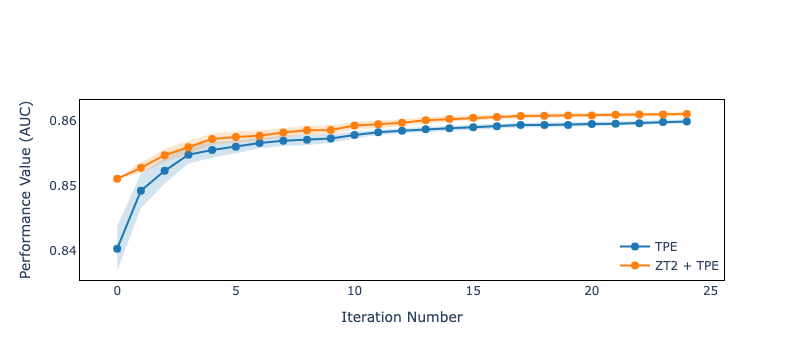

Figure saved to plots/core_ZT_WS_SOTA_vs_SOTA_Performance_Dataset_1494.pdf


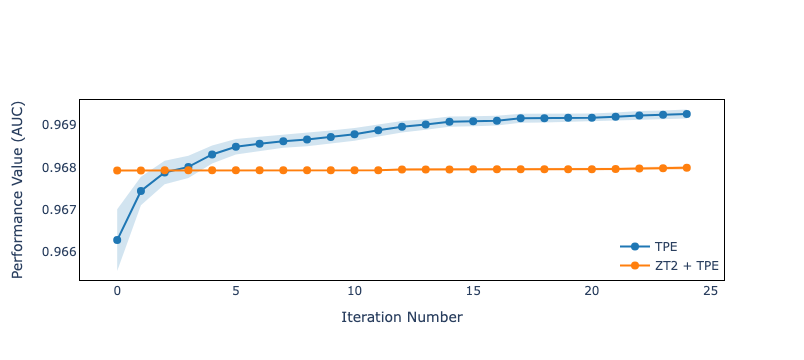

Figure saved to plots/core_ZT_WS_SOTA_vs_SOTA_Performance_Dataset_1510.pdf


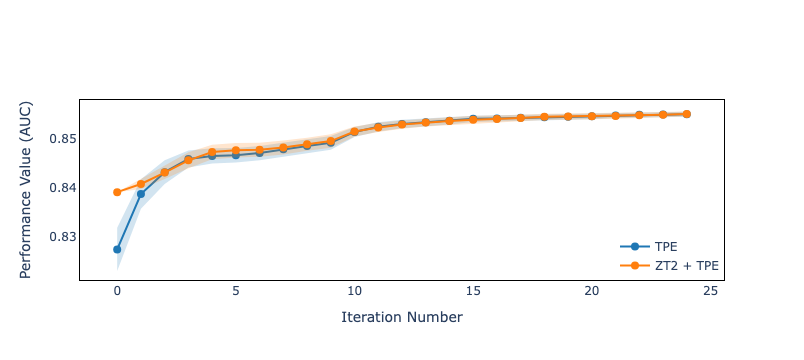

Figure saved to plots/core_ZT_WS_SOTA_vs_SOTA_Performance_Dataset_1558.pdf


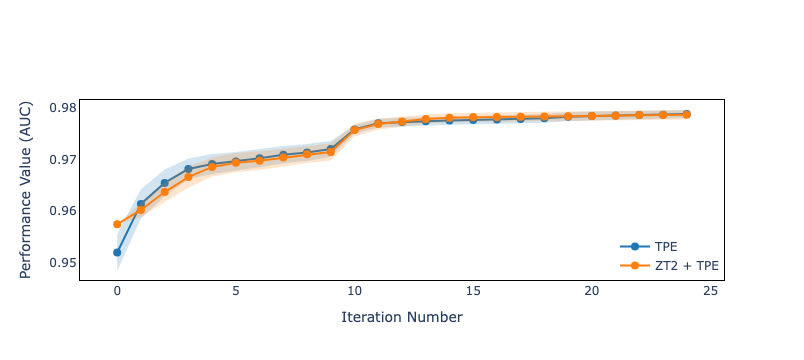

Figure saved to plots/core_ZT_WS_SOTA_vs_SOTA_Performance_Dataset_4534.pdf


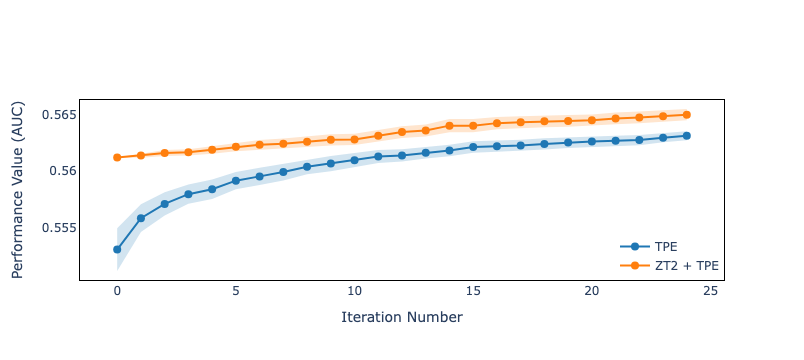

Figure saved to plots/core_ZT_WS_SOTA_vs_SOTA_Performance_Dataset_23381.pdf


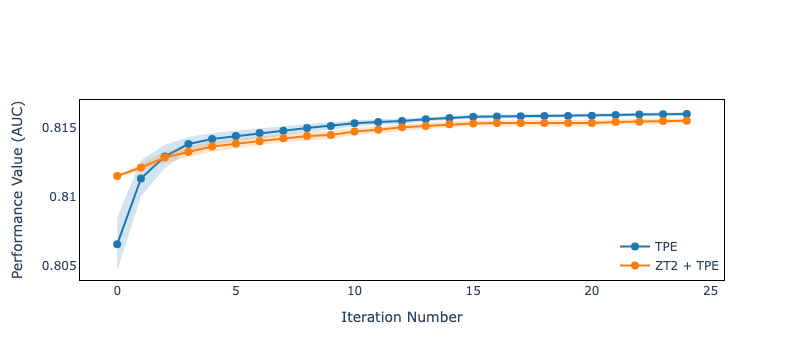

Figure saved to plots/core_ZT_WS_SOTA_vs_SOTA_Performance_Dataset_40536.pdf


In [39]:
dataset_id_list = [38, 179, 298, 917, 1049, 1111, 1120, 1128, 1169, 1597, 42206]
dataset_id_list = [917, 1049, 1111, 1464, 1494, 1510, 1558, 4534, 23381, 40536]

for dataset_id in dataset_id_list:
    plot_hpo_performance(df_kb_optuna_trials, df_zt_ws_optuna_trials #, ws_results_df
                     , dataset=dataset_id, exclude_default=True
                     , save_file=True, only_increasing=True
                     , plot_all_traces=False, show_confidence_interval=True, remove_headers=True, max_iter=25, file_prefix='core')

In [142]:
df = ws_results_df

#sig_test_results_df = stats_test(df, column1="_SOTA_n20_seed_scores_", column2="ZT_SOTA_n20_seed_scores_ZT")
#path = f'{output_root}ZTWS_real_world_signficant_results_retrain_{retrain}_{KB_TYPE}_kb.csv'
#print(f'Saved to: {path}')
#sig_test_results_df.to_csv(path, index=False)

for hpo_iteration in(1, 2, 5, 10, 20):
    print(hpo_iteration)
    sig_test_results_df = stats_test(df, column1=f"ZT_SOTA_n{hpo_iteration}_seed_scores_ZT" , column2=f"_SOTA_n{hpo_iteration}_seed_scores_")
    path = f'{output_root}ZTWS_real_world_signficant_results_SOTA_N{hpo_iteration}_retrain_{retrain}_{KB_TYPE}_kb.csv'
    print(f'Saved to: {path}')
    sig_test_results_df.to_csv(path, index=False)

1
--- 
ZT_SOTA_n1_seed_scores_ZT  vs  _SOTA_n1_seed_scores_


,Dataset,ZT_SOTA_n1_seed_scores_ZT,_SOTA_n1_seed_scores_,Best Method,t_stat,p_value,Significant,Uplift (%)
0,917,0.892689,0.892870,_SOTA_n1_seed_scores_,-0.109484,9.132659e-01,False,-0.020236
1,1049,0.892803,0.888514,ZT_SOTA_n1_seed_scores_ZT,6.462330,4.517355e-08,True,0.482740
2,1111,0.800002,0.794068,ZT_SOTA_n1_seed_scores_ZT,8.553161,2.759091e-11,True,0.747340
3,1464,0.709685,0.705803,ZT_SOTA_n1_seed_scores_ZT,8.787372,1.225792e-11,True,0.549932
4,1494,0.852742,0.849216,ZT_SOTA_n1_seed_scores_ZT,2.905272,5.492727e-03,True,0.415213
5,1510,0.967926,0.967443,ZT_SOTA_n1_seed_scores_ZT,2.907040,5.466383e-03,True,0.049873
6,1558,0.840757,0.838703,ZT_SOTA_n1_seed_scores_ZT,1.499450,1.401727e-01,False,0.244895
7,4534,0.960212,0.961383,_SOTA_n1_seed_scores_,-0.965609,3.389815e-01,False,-0.121806
8,23381,0.561372,0.555862,ZT_SOTA_n1_seed_scores_ZT,9.289580,2.192100e-12,True,0.991328
9,40536,0.812118,0.811322,ZT_SOTA_n1_seed_scores_ZT,1.332374,1.889007e-01,False,0.098078


Saved to: ./output/20240812/ZTWS_real_world_signficant_results_SOTA_N1_retrain_False_real_world_kb.csv
2
--- 
ZT_SOTA_n2_seed_scores_ZT  vs  _SOTA_n2_seed_scores_


,Dataset,ZT_SOTA_n2_seed_scores_ZT,_SOTA_n2_seed_scores_,Best Method,t_stat,p_value,Significant,Uplift (%)
0,917,0.896254,0.897064,_SOTA_n2_seed_scores_,-0.692338,4.919931e-01,False,-0.090275
1,1049,0.892880,0.889965,ZT_SOTA_n2_seed_scores_ZT,5.420917,1.800360e-06,True,0.327505
2,1111,0.800097,0.795961,ZT_SOTA_n2_seed_scores_ZT,7.615155,7.439239e-10,True,0.519692
3,1464,0.709715,0.706733,ZT_SOTA_n2_seed_scores_ZT,7.843711,3.314537e-10,True,0.421952
4,1494,0.854692,0.852284,ZT_SOTA_n2_seed_scores_ZT,3.237475,2.165908e-03,True,0.282443
5,1510,0.967932,0.967878,ZT_SOTA_n2_seed_scores_ZT,0.397549,6.926891e-01,False,0.005572
6,1558,0.843102,0.843185,_SOTA_n2_seed_scores_,-0.087128,9.309248e-01,False,-0.009816
7,4534,0.963673,0.965452,_SOTA_n2_seed_scores_,-2.021022,4.875884e-02,True,-0.184217
8,23381,0.561600,0.557116,ZT_SOTA_n2_seed_scores_ZT,9.357127,1.742593e-12,True,0.804846
9,40536,0.812841,0.812912,_SOTA_n2_seed_scores_,-0.202886,8.400643e-01,False,-0.008689


Saved to: ./output/20240812/ZTWS_real_world_signficant_results_SOTA_N2_retrain_False_real_world_kb.csv
5
--- 
ZT_SOTA_n5_seed_scores_ZT  vs  _SOTA_n5_seed_scores_


,Dataset,ZT_SOTA_n5_seed_scores_ZT,_SOTA_n5_seed_scores_,Best Method,t_stat,p_value,Significant,Uplift (%)
0,917,0.902831,0.903634,_SOTA_n5_seed_scores_,-2.039613,4.679978e-02,True,-0.088854
1,1049,0.893271,0.892881,ZT_SOTA_n5_seed_scores_ZT,1.280697,2.063290e-01,False,0.043676
2,1111,0.800649,0.798651,ZT_SOTA_n5_seed_scores_ZT,6.551124,3.291087e-08,True,0.250243
3,1464,0.710035,0.708137,ZT_SOTA_n5_seed_scores_ZT,5.942127,2.873413e-07,True,0.268027
4,1494,0.857508,0.855980,ZT_SOTA_n5_seed_scores_ZT,6.980695,7.106547e-09,True,0.178508
5,1510,0.967932,0.968483,_SOTA_n5_seed_scores_,-6.160721,1.322499e-07,True,-0.056881
6,1558,0.847685,0.846665,ZT_SOTA_n5_seed_scores_ZT,6.207329,1.120471e-07,True,0.120456
7,4534,0.969348,0.969595,_SOTA_n5_seed_scores_,-1.215489,2.300038e-01,False,-0.025471
8,23381,0.562138,0.559162,ZT_SOTA_n5_seed_scores_ZT,9.455020,1.250673e-12,True,0.532311
9,40536,0.813834,0.814391,_SOTA_n5_seed_scores_,-4.417491,5.510790e-05,True,-0.068386


Saved to: ./output/20240812/ZTWS_real_world_signficant_results_SOTA_N5_retrain_False_real_world_kb.csv
10
--- 
ZT_SOTA_n10_seed_scores_ZT  vs  _SOTA_n10_seed_scores_


,Dataset,ZT_SOTA_n10_seed_scores_ZT,_SOTA_n10_seed_scores_,Best Method,t_stat,p_value,Significant,Uplift (%)
0,917,0.907471,0.907391,ZT_SOTA_n10_seed_scores_ZT,0.280194,7.805085e-01,False,0.008850
1,1049,0.894067,0.894371,_SOTA_n10_seed_scores_,-1.562835,1.245274e-01,False,-0.034039
2,1111,0.801545,0.800501,ZT_SOTA_n10_seed_scores_ZT,7.818800,3.619308e-10,True,0.130450
3,1464,0.710839,0.709634,ZT_SOTA_n10_seed_scores_ZT,5.135025,4.860699e-06,True,0.169804
4,1494,0.859263,0.857815,ZT_SOTA_n10_seed_scores_ZT,5.556936,1.118185e-06,True,0.168854
5,1510,0.967932,0.968778,_SOTA_n10_seed_scores_,-11.568502,1.285092e-15,True,-0.087261
6,1558,0.851513,0.851428,ZT_SOTA_n10_seed_scores_ZT,0.324730,7.467679e-01,False,0.010010
7,4534,0.975677,0.975795,_SOTA_n10_seed_scores_,-0.265195,7.919719e-01,False,-0.012101
8,23381,0.562790,0.560968,ZT_SOTA_n10_seed_scores_ZT,6.594512,2.819101e-08,True,0.324933
9,40536,0.814726,0.815314,_SOTA_n10_seed_scores_,-6.327824,7.296130e-08,True,-0.072154


Saved to: ./output/20240812/ZTWS_real_world_signficant_results_SOTA_N10_retrain_False_real_world_kb.csv
20
--- 
ZT_SOTA_n20_seed_scores_ZT  vs  _SOTA_n20_seed_scores_


,Dataset,ZT_SOTA_n20_seed_scores_ZT,_SOTA_n20_seed_scores_,Best Method,t_stat,p_value,Significant,Uplift (%)
0,917,0.909637,0.909027,ZT_SOTA_n20_seed_scores_ZT,3.563092,8.282435e-04,True,0.067132
1,1049,0.895618,0.896661,_SOTA_n20_seed_scores_,-3.840400,3.531142e-04,True,-0.116335
2,1111,0.803394,0.802575,ZT_SOTA_n20_seed_scores_ZT,4.007918,2.081702e-04,True,0.102072
3,1464,0.712268,0.710414,ZT_SOTA_n20_seed_scores_ZT,15.878774,5.911367e-21,True,0.260943
4,1494,0.860817,0.859487,ZT_SOTA_n20_seed_scores_ZT,7.334155,2.017562e-09,True,0.154704
5,1510,0.967955,0.969170,_SOTA_n20_seed_scores_,-24.260018,5.895441e-29,True,-0.125328
6,1558,0.854652,0.854637,ZT_SOTA_n20_seed_scores_ZT,0.046321,9.632424e-01,False,0.001763
7,4534,0.978397,0.978415,_SOTA_n20_seed_scores_,-0.046667,9.629686e-01,False,-0.001847
8,23381,0.564484,0.562601,ZT_SOTA_n20_seed_scores_ZT,6.529867,3.550358e-08,True,0.334669
9,40536,0.815338,0.815860,_SOTA_n20_seed_scores_,-5.604639,9.457080e-07,True,-0.063968


Saved to: ./output/20240812/ZTWS_real_world_signficant_results_SOTA_N20_retrain_False_real_world_kb.csv


In [143]:
# Load saved results
#sig_test_results_df_random = pd.read_csv(f'{output_root}ZTWS_real_world_signficant_results_random_retrain_{retrain}_{KB_TYPE}_kb.csv')
sig_test_results_df_SOTA_N1 = pd.read_csv(f'{output_root}ZTWS_real_world_signficant_results_SOTA_N1_retrain_{retrain}_{KB_TYPE}_kb.csv')
sig_test_results_df_SOTA_N5 = pd.read_csv(f'{output_root}ZTWS_real_world_signficant_results_SOTA_N5_retrain_{retrain}_{KB_TYPE}_kb.csv')
sig_test_results_df_SOTA_N10 = pd.read_csv(f'{output_root}ZTWS_real_world_signficant_results_SOTA_N10_retrain_{retrain}_{KB_TYPE}_kb.csv')
sig_test_results_df_SOTA_N20 = pd.read_csv(f'{output_root}ZTWS_real_world_signficant_results_SOTA_N20_retrain_{retrain}_{KB_TYPE}_kb.csv')

#calculate_best_and_significant_percentages(sig_test_results_df_random)
agg_N1 = calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N1)
agg_N5 = calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N5)
agg_N10 = calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N10)
agg_N20 = calculate_best_and_significant_percentages(sig_test_results_df_SOTA_N20)

,HPO Method,Total Count,Significant Count,Best Percentage,Significant Percentage
0,ZT_SOTA_n1_seed_scores_ZT,8,6.0,80.0,60.0
1,_SOTA_n1_seed_scores_,2,0.0,20.0,0.0


,HPO Method,Total Count,Significant Count,Best Percentage,Significant Percentage
0,ZT_SOTA_n5_seed_scores_ZT,6,5,60.0,50.0
1,_SOTA_n5_seed_scores_,4,3,40.0,30.0


,HPO Method,Total Count,Significant Count,Best Percentage,Significant Percentage
0,ZT_SOTA_n10_seed_scores_ZT,6,4,60.0,40.0
1,_SOTA_n10_seed_scores_,4,2,40.0,20.0


,HPO Method,Total Count,Significant Count,Best Percentage,Significant Percentage
0,ZT_SOTA_n20_seed_scores_ZT,6,5,60.0,50.0
1,_SOTA_n20_seed_scores_,4,3,40.0,30.0


In [144]:
agg_N1.to_csv(f'{output_root}ZTWS_real_world_Agg_results_N1_{KB_TYPE}_kb.csv', index=False)
agg_N5.to_csv(f'{output_root}ZTWS_real_world_Agg_results_N5_{KB_TYPE}_kb.csv', index=False)
agg_N10.to_csv(f'{output_root}ZTWS_real_world_Agg_results_N10_{KB_TYPE}_kb.csv', index=False)
agg_N20.to_csv(f'{output_root}ZTWS_real_world_Agg_results_N20_{KB_TYPE}_kb.csv', index=False)

In [145]:
output_root

'./output/20240812/'

#### DEBUGGING WORK 

In [ ]:
# DEBUG why Method 1 differs from Method 2
# Method1: “Max-of-Means”

optuna_trials_1 = df_zt_ws_optuna_trials 
optuna_trials_2 = df_kb_optuna_trials # original SOTA results pandas dataframe
dataset = 1464
max_iter = 20
only_increasing=True

def compute_avg_best_so_far(df, only_increasing=True):
    # Sort by seed and number
    df_sorted = df.sort_values(['seed', 'number']).copy()
    
    # For each seed, compute the running best (cummax) of 'value'
    df_sorted['cummax_value'] = df_sorted.groupby('seed')['value'].cummax()
    
    # For each iteration, compute mean, std, count of seed-level best-so-far
    df_stats = df_sorted.groupby('number')['cummax_value'].agg(['mean', 'std', 'count']).reset_index()
    
    # Standard error of the mean
    df_stats['sem'] = df_stats['std'] / df_stats['count']**0.5
    
    # Optionally ensure the final reported column is non-decreasing across iterations
    # The column 'mean' is already the "average best-so-far at each iteration".
    # If you want to make sure it never decreases, you can do:
    if only_increasing:
        df_stats['mean_cummax'] = df_stats['mean'].cummax()
    else:
        df_stats['mean_cummax'] = df_stats['mean']
    
    return df_stats

# Filter the dataframes based on the Dataset column if dataset is provided
#df_sota_trials_1_filtered = optuna_trials_1[optuna_trials_1['Dataset'] == dataset] if dataset else optuna_trials_1.copy()
df_sota_trials_1_filtered = optuna_trials_1[
    (optuna_trials_1['Dataset'] == dataset) & (optuna_trials_1['number'] <= max_iter)
] if dataset else optuna_trials_1[optuna_trials_1['number'] <= max_iter].copy()

#df_sota_trials_2_filtered = optuna_trials_2[optuna_trials_2['Dataset'] == dataset] if optuna_trials_2 is not None and dataset else None
df_sota_trials_2_filtered = optuna_trials_2[
    (optuna_trials_2['Dataset'] == dataset) & (optuna_trials_2['number'] <= max_iter)
] if dataset else optuna_trials_2[optuna_trials_2['number'] <= max_iter].copy()

# Calculate the mean and standard deviation for the first DataFrame
#df_stats_1 = df_sota_trials_1_filtered.groupby("number")["value"].agg(['mean', 'std', 'count']).reset_index()
#df_stats_1['sem'] = df_stats_1['std'] / df_stats_1['count']**0.5
## Apply cumulative maximum if only_increasing is True
#df_stats_1['mean_cummax'] = df_stats_1['mean'].cummax() if only_increasing else df_stats_1['mean']

df_stats_1 = compute_avg_best_so_far(df_sota_trials_1_filtered, only_increasing=only_increasing)
best_perf_1_after_20 = df_stats_1.loc[df_stats_1['number'] <= 20, 'mean_cummax'].max()

print('Warm started SOTA Results after 20 iterations (Method 2 logic):')
display(best_perf_1_after_20)


## Calculate the mean and standard deviation for the second DataFrame
#df_stats_2 = df_sota_trials_2_filtered.groupby("number")["value"].agg(['mean', 'std', 'count']).reset_index()
#df_stats_2['sem'] = df_stats_2['std'] / df_stats_2['count']**0.5
#df_stats_2['mean_cummax'] = df_stats_2['mean'].cummax() if only_increasing else df_stats_2['mean']
df_stats_2 = compute_avg_best_so_far(df_sota_trials_2_filtered, only_increasing=only_increasing)
best_perf_2_after_20 = df_stats_2.loc[df_stats_2['number'] <= 20, 'mean_cummax'].max()

print('Original SOTA Results after 20 iterations (Method 2 logic):')
display(best_perf_2_after_20)

#print('Warm started SOTA Results after 20 iterations:')
#display(df_stats_1['mean_cummax'].max())
#"0.7095470016850035"

#print('Original SOTA Results after 20 iterations:')
#display(df_stats_2['mean_cummax'].max())
#"0.7081730141738527"


# Alternate Method for calculating best performance at certain iteration checkpoints.
# Method 2: "Mean-of-Maxes"

def calculate_average_best_performance(df):
    """
    Calculates the average best performance at each iteration across all seeds,
    and keeps the max for each seed per iteration in another column.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing at least 'number', 'value', and 'seed' columns.

    Returns:
    - pd.DataFrame: A DataFrame with 'number', 'average_best_performance', and 'seed_max_values' columns.
    """
    # Ensure the DataFrame is sorted by 'seed' and 'number' for proper cumulative calculations
    df_sorted = df.sort_values(['seed', 'number']).copy()
    
    # Calculate the cumulative maximum of 'value' for each 'seed'
    df_sorted['cummax_value'] = df_sorted.groupby('seed')['value'].cummax()
    
    # For each iteration, calculate the average best performance and collect the seed max values
    df_stats = df_sorted.groupby('number').agg(
        average_best_performance=('cummax_value', 'mean'),
        seed_max_values=('cummax_value', lambda x: list(x))
    ).reset_index()
    
    return df_stats

def extract_performance_at_iterations(df_avg_best, hpo_iterations, prefix=""):
    """
    Extracts the average best performance and seed max values at specified iterations.

    Parameters:
    - df_avg_best (pd.DataFrame): DataFrame containing 'number', 'average_best_performance', and 'seed_max_values'.
    - hpo_iterations (list): List of iteration numbers to extract data from.

    Returns:
    - sota_performance (dict): Dictionary with keys as 'SOTA_n{n}_performance' and values as average best performance.
    - sota_seed_scores (dict): Dictionary with keys as 'SOTA_n{n}_seed_scores' and values as lists of seed max values.
    """
    sota_performance = {}
    sota_seed_scores = {}
    for n in hpo_iterations:
        # Check if iteration n exists in df_avg_best
        if n in df_avg_best['number'].values:
            row = df_avg_best[df_avg_best['number'] == n].iloc[0]
            avg_perf = row['average_best_performance']
            seed_scores = row['seed_max_values']
            sota_performance[f'{prefix}SOTA_n{n}_performance'] = avg_perf
            # If seed_max_values is a dictionary, extract the values
            if isinstance(seed_scores, dict):
                sota_seed_scores[f'{prefix}SOTA_n{n}_seed_scores'] = list(seed_scores.values())
            else:
                sota_seed_scores[f'{prefix}_SOTA_n{n}_seed_scores_{prefix}'] = seed_scores
        else:
            print(f"Iteration {n} not found in the data.")
            sota_performance[f'{prefix}SOTA_n{n}_performance'] = None
            sota_seed_scores[f'{prefix}SOTA_n{n}_seed_scores'] = None
    return sota_performance, sota_seed_scores

hpo_iterations = [0, 1, 2, 5, 10, 20]

df_ws_sota_avg_best = calculate_average_best_performance(df_sota_trials_1_filtered)
ws_sota_performance, ws_sota_seed_scores = extract_performance_at_iterations(df_ws_sota_avg_best, hpo_iterations)
print('Warm Start SOTA Results at certain iterations:')
display(ws_sota_performance)
"""
{'SOTA_n0_performance': 0.7095470016850035,
 'SOTA_n1_performance': 0.7096849328972148,
 'SOTA_n2_performance': 0.7097152838735257,
 'SOTA_n5_performance': 0.7100345869759144,
 'SOTA_n10_performance': 0.7108391067499257,
 'SOTA_n20_performance': 0.7122680096144316}
"""

df_sota_avg_best = calculate_average_best_performance(df_sota_trials_2_filtered)
sota_performance, sota_seed_scores = extract_performance_at_iterations(df_sota_avg_best, hpo_iterations)

print('Original SOTA Results at certain iterations:')
display(sota_performance)
"""
{'SOTA_n0_performance': 0.7033931152740608,
 'SOTA_n1_performance': 0.7058034906829219,
 'SOTA_n2_performance': 0.7067332104271979,
 'SOTA_n5_performance': 0.7081365873723857,
 'SOTA_n10_performance': 0.7096341195856875,
 'SOTA_n20_performance': 0.7104142315888592}
 """